In [2]:
import gymnasium as gym
import gymnasium_robotics as gymr
from stable_baselines3 import A2C, SAC, PPO, TD3, DDPG, HerReplayBuffer
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import TQC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sb3_contrib.common.wrappers.time_feature import TimeFeatureWrapper
import psutil
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import numpy as np
import multiprocessing

In [3]:
num_cpu_cores = multiprocessing.cpu_count()
num_cpu_cores

32

In [3]:
env = gym.make('FetchPickAndPlace-v2')

## TQC

In [4]:
def linear_schedule(initial_value: float):
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [5]:
def make_env(env_id, rank, seed=0, render_mode=None):
    def _init():
        env = gym.make(env_id, max_episode_steps=100, render_mode=render_mode)
        # Check if the environment has a `seed` method
        if hasattr(env.unwrapped, 'seed'):
            env.unwrapped.seed(seed + rank)
        return env
    return _init

In [6]:
env_id = 'FetchPickAndPlace-v2'
num_envs = 20  # Number of parallel environments

In [7]:
#envs = SubprocVecEnv([make_env(env_id, i) for i in range(num_envs)])
envs = DummyVecEnv([make_env(env_id, i) for i in range(num_envs)])

In [8]:
eval_env = DummyVecEnv([make_env(env_id, 20)])

In [8]:
tqc_model = TQC(
                'MultiInputPolicy',
                envs,
                replay_buffer_class=HerReplayBuffer,
                replay_buffer_kwargs=dict(
                    n_sampled_goal=4,
                    goal_selection_strategy="future"
                ),
                learning_rate=linear_schedule(0.001),
                batch_size=512,
                buffer_size=1000000,
                learning_starts=2100,
                train_freq=1,
                gradient_steps=-1,
                gamma=0.98,
                tau=0.005,
                policy_kwargs=dict(n_critics=2, net_arch=[128, 256, 64]),
                verbose=1,
            )

Using cuda device


In [9]:
eval_callback = EvalCallback(eval_env, 
                             best_model_save_path='./results/models/tq3',
                             log_path='./results/logs/tq3', 
                             eval_freq=10000 // num_envs,
                             deterministic=True,
                             n_eval_episodes=20,
                             render=False)

In [ ]:
model.learn(total_timesteps=3000000, callback=eval_callback)

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1440     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1440     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1439     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 24       |
|    fps             | 373      |
|    time_elapsed    | 10       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -6.83    |
|    critic_loss     | 0.00894  |
|    ent_coef        | 0.155    |
|    ent_coef_loss   | -12.4    |
|    learning_rate   | 0.000999 |
|    n_updates       | 1880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 28       |
|    fps             | 373      |
|    time_elapsed    | 10       |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes 

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-100.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Success rate: 0.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -100     |
|    success_rate    | 0.0      |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | -0.196   |
|    critic_loss     | 0.0542   |
|    ent_coef        | 0.00387  |
|    ent_coef_loss   | -26.6    |
|    learning_rate   | 0.000997 |
|    n_updates       | 7880     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 231      |
|    time_elapsed    | 43       |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/        

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 219      |
|    time_elapsed    | 82       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 219      |
|    time_elapsed    | 82       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 219      |
|    time_elapsed    | 82       |
|    total_timesteps | 18000    |
---------------------------------
Eval num_timesteps=20000, episode_reward=-85.00 +/- 35.71
Episode length: 100.00 +

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 208      |
|    time_elapsed    | 134      |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | 7.69     |
|    critic_loss     | 0.0477   |
|    ent_coef        | 0.00131  |
|    ent_coef_loss   | -12.5    |
|    learning_rate   | 0.000991 |
|    n_updates       | 25880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 208      |
|    time_elapsed    | 134      |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 352      |
|    fps             | 204      |
|    time_elapsed    | 176      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 356      |
|    fps             | 204      |
|    time_elapsed    | 176      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 360      |
|    fps             | 204      |
|    time_elapsed    | 176      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 444      |
|    fps             | 200      |
|    time_elapsed    | 229      |
|    total_timesteps | 46000    |
| train/             |          |
|    actor_loss      | 10.2     |
|    critic_loss     | 0.135    |
|    ent_coef        | 0.00149  |
|    ent_coef_loss   | -13.7    |
|    learning_rate   | 0.000985 |
|    n_updates       | 43880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 448      |
|    fps             | 200      |
|    time_elapsed    | 229      |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 532      |
|    fps             | 196      |
|    time_elapsed    | 274      |
|    total_timesteps | 54000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 536      |
|    fps             | 196      |
|    time_elapsed    | 274      |
|    total_timesteps | 54000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 540      |
|    fps             | 196      |
|    time_elapsed    | 274      |
|    total_timesteps | 54000    |
---------------------------------


## DDPG + HER

In [112]:
ddpg_model = DDPG(
    policy="MultiInputPolicy",
    env=envs,
    learning_rate=linear_schedule(0.001),
    buffer_size=1000000,
    learning_starts=2100,
    batch_size=256,
    tau=0.005,
    gamma=0.98,
    train_freq=8,
    gradient_steps=4,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future"
    ),
    policy_kwargs=dict(n_critics=2, net_arch=[256, 256, 64]),
    action_noise=NormalActionNoise(mean=np.zeros(envs.action_space.shape), sigma=0.05 * np.ones(envs.action_space.shape)),
    verbose=1
)

Using cuda device


In [113]:
ddpg_eval_callback = EvalCallback(eval_env, 
                             best_model_save_path='./results/models/ddpg',
                             log_path='./results/logs/ddpg', 
                             eval_freq=10000 // num_envs,
                             deterministic=True,
                             n_eval_episodes=100,
                             render=False)

In [114]:
ddpg_model.learn(3000000, callback=ddpg_eval_callback)

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1474     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1473     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1473     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1416     |
|    time_elapsed    | 2        |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.319    |
|    critic_loss     | 0.326    |
|    learning_rate   | 0.000999 |
|    n_updates       | 44       |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1416     |
|    time_elapsed    | 2        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1415     |
|    time_elap

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 0.48     |
|    critic_loss     | 0.194    |
|    learning_rate   | 0.000997 |
|    n_updates       | 196      |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 603      |
|    time_elapsed    | 16       |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/           

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 801      |
|    time_elapsed    | 22       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 801      |
|    time_elapsed    | 22       |
|    total_timesteps | 18000    |
---------------------------------
Eval num_timesteps=20000, episode_reward=-99.00 +/- 9.95
Episode length: 100.00 +/- 0.00
Success rate: 1.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -99      |
|    success_rate    | 0.01     |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    ac

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 715      |
|    time_elapsed    | 39       |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 715      |
|    time_elapsed    | 39       |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 715      |
|    time_elapsed    | 39       |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 680      |
|    time_elapsed    | 55       |
|    total_timesteps | 38000    |
| train/             |          |
|    actor_loss      | 1.09     |
|    critic_loss     | 0.0707   |
|    learning_rate   | 0.000987 |
|    n_updates       | 896      |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 368      |
|    fps             | 680      |
|    time_elapsed    | 55       |
|    total_timesteps | 38000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 372      |
|    fps             | 680      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 456      |
|    fps             | 647      |
|    time_elapsed    | 71       |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 460      |
|    fps             | 647      |
|    time_elapsed    | 71       |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 464      |
|    fps             | 661      |
|    time_elapsed    | 72       |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 0.577    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 548      |
|    fps             | 638      |
|    time_elapsed    | 87       |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 552      |
|    fps             | 638      |
|    time_elapsed    | 87       |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 556      |
|    fps             | 638      |
|    time_elapsed    | 87       |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 644      |
|    fps             | 631      |
|    time_elapsed    | 104      |
|    total_timesteps | 66000    |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 0.814    |
|    learning_rate   | 0.000978 |
|    n_updates       | 1596     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 648      |
|    fps             | 631      |
|    time_elapsed    | 104      |
|    total_timesteps | 66000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 652      |
|    fps             | 631      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 736      |
|    fps             | 617      |
|    time_elapsed    | 119      |
|    total_timesteps | 74000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 740      |
|    fps             | 617      |
|    time_elapsed    | 119      |
|    total_timesteps | 74000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 744      |
|    fps             | 626      |
|    time_elapsed    | 121      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | 1.2      |
|    critic_loss     | 0.881    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 828      |
|    fps             | 614      |
|    time_elapsed    | 136      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 832      |
|    fps             | 614      |
|    time_elapsed    | 136      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 836      |
|    fps             | 614      |
|    time_elapsed    | 136      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 924      |
|    fps             | 613      |
|    time_elapsed    | 153      |
|    total_timesteps | 94000    |
| train/             |          |
|    actor_loss      | 1.42     |
|    critic_loss     | 0.416    |
|    learning_rate   | 0.000969 |
|    n_updates       | 2296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 928      |
|    fps             | 613      |
|    time_elapsed    | 153      |
|    total_timesteps | 94000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 932      |
|    fps             | 613      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1016     |
|    fps             | 604      |
|    time_elapsed    | 168      |
|    total_timesteps | 102000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1020     |
|    fps             | 604      |
|    time_elapsed    | 168      |
|    total_timesteps | 102000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 611      |
|    time_elapsed    | 170      |
|    total_timesteps | 104000   |
| train/             |          |
|    actor_loss      | 1.76     |
|    critic_loss     | 0.0606   |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1108     |
|    fps             | 601      |
|    time_elapsed    | 186      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1112     |
|    fps             | 601      |
|    time_elapsed    | 186      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1116     |
|    fps             | 601      |
|    time_elapsed    | 186      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 599      |
|    time_elapsed    | 203      |
|    total_timesteps | 122000   |
| train/             |          |
|    actor_loss      | 1.92     |
|    critic_loss     | 0.0728   |
|    learning_rate   | 0.000959 |
|    n_updates       | 2996     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 599      |
|    time_elapsed    | 203      |
|    total_timesteps | 122000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1212     |
|    fps             | 599      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 592      |
|    time_elapsed    | 219      |
|    total_timesteps | 130000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 592      |
|    time_elapsed    | 219      |
|    total_timesteps | 130000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 597      |
|    time_elapsed    | 220      |
|    total_timesteps | 132000   |
| train/             |          |
|    actor_loss      | 2.18     |
|    critic_loss     | 0.133    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 591      |
|    time_elapsed    | 236      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1392     |
|    fps             | 591      |
|    time_elapsed    | 236      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1396     |
|    fps             | 591      |
|    time_elapsed    | 236      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1484     |
|    fps             | 590      |
|    time_elapsed    | 254      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1488     |
|    fps             | 590      |
|    time_elapsed    | 254      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1492     |
|    fps             | 590      |
|    time_elapsed    | 254      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=160000, episode_reward=-100.00 +/- 0.00
Episode length: 100.00 +/- 0.00
Success rate: 0.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -100     |
|    success_rate    | 0.0      |
| time/              |          |
|    total_timesteps | 160000   |
| train/             |          |
|    actor_loss      | 2.59     |
|    critic_loss     | 0.199    |
|    learning_rate   | 0.000947 |
|    n_updates       | 3944     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1584     |
|    fps             | 590      |
|    time_elapsed    | 270      |
|    total_timesteps | 160000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1676     |
|    fps             | 607      |
|    time_elapsed    | 276      |
|    total_timesteps | 168000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1680     |
|    fps             | 607      |
|    time_elapsed    | 276      |
|    total_timesteps | 168000   |
---------------------------------
Eval num_timesteps=170000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 170000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1768     |
|    fps             | 606      |
|    time_elapsed    | 293      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 606      |
|    time_elapsed    | 293      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 606      |
|    time_elapsed    | 293      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1864     |
|    fps             | 606      |
|    time_elapsed    | 310      |
|    total_timesteps | 188000   |
| train/             |          |
|    actor_loss      | 2.6      |
|    critic_loss     | 19.6     |
|    learning_rate   | 0.000937 |
|    n_updates       | 4644     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 606      |
|    time_elapsed    | 310      |
|    total_timesteps | 188000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1872     |
|    fps             | 606      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1956     |
|    fps             | 602      |
|    time_elapsed    | 325      |
|    total_timesteps | 196000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1960     |
|    fps             | 602      |
|    time_elapsed    | 325      |
|    total_timesteps | 196000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 1964     |
|    fps             | 605      |
|    time_elapsed    | 326      |
|    total_timesteps | 198000   |
| train/             |          |
|    actor_loss      | 4.01     |
|    critic_loss     | 0.274    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 602      |
|    time_elapsed    | 341      |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2052     |
|    fps             | 602      |
|    time_elapsed    | 341      |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2056     |
|    fps             | 602      |
|    time_elapsed    | 341      |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2144     |
|    fps             | 602      |
|    time_elapsed    | 358      |
|    total_timesteps | 216000   |
| train/             |          |
|    actor_loss      | 3.83     |
|    critic_loss     | 0.15     |
|    learning_rate   | 0.000928 |
|    n_updates       | 5344     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2148     |
|    fps             | 602      |
|    time_elapsed    | 358      |
|    total_timesteps | 216000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2152     |
|    fps             | 602      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2236     |
|    fps             | 599      |
|    time_elapsed    | 373      |
|    total_timesteps | 224000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 599      |
|    time_elapsed    | 373      |
|    total_timesteps | 224000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 602      |
|    time_elapsed    | 375      |
|    total_timesteps | 226000   |
| train/             |          |
|    actor_loss      | 4.18     |
|    critic_loss     | 0.554    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2328     |
|    fps             | 599      |
|    time_elapsed    | 390      |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2332     |
|    fps             | 599      |
|    time_elapsed    | 390      |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2336     |
|    fps             | 599      |
|    time_elapsed    | 390      |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2424     |
|    fps             | 599      |
|    time_elapsed    | 407      |
|    total_timesteps | 244000   |
| train/             |          |
|    actor_loss      | 4.19     |
|    critic_loss     | 0.345    |
|    learning_rate   | 0.000919 |
|    n_updates       | 6044     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2428     |
|    fps             | 599      |
|    time_elapsed    | 407      |
|    total_timesteps | 244000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2432     |
|    fps             | 599      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2516     |
|    fps             | 596      |
|    time_elapsed    | 422      |
|    total_timesteps | 252000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2520     |
|    fps             | 596      |
|    time_elapsed    | 422      |
|    total_timesteps | 252000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 599      |
|    time_elapsed    | 423      |
|    total_timesteps | 254000   |
| train/             |          |
|    actor_loss      | 4.14     |
|    critic_loss     | 0.157    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2608     |
|    fps             | 596      |
|    time_elapsed    | 439      |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2612     |
|    fps             | 596      |
|    time_elapsed    | 439      |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2616     |
|    fps             | 596      |
|    time_elapsed    | 439      |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2704     |
|    fps             | 596      |
|    time_elapsed    | 455      |
|    total_timesteps | 272000   |
| train/             |          |
|    actor_loss      | 4.36     |
|    critic_loss     | 0.109    |
|    learning_rate   | 0.000909 |
|    n_updates       | 6744     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2708     |
|    fps             | 596      |
|    time_elapsed    | 455      |
|    total_timesteps | 272000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2712     |
|    fps             | 596      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2796     |
|    fps             | 594      |
|    time_elapsed    | 471      |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2800     |
|    fps             | 594      |
|    time_elapsed    | 471      |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 2804     |
|    fps             | 596      |
|    time_elapsed    | 472      |
|    total_timesteps | 282000   |
| train/             |          |
|    actor_loss      | 4.83     |
|    critic_loss     | 0.213    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2888     |
|    fps             | 594      |
|    time_elapsed    | 487      |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2892     |
|    fps             | 594      |
|    time_elapsed    | 487      |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2896     |
|    fps             | 594      |
|    time_elapsed    | 487      |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2984     |
|    fps             | 594      |
|    time_elapsed    | 504      |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2988     |
|    fps             | 594      |
|    time_elapsed    | 504      |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2992     |
|    fps             | 594      |
|    time_elapsed    | 504      |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=310000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 310000   |
| train/             |          |
|    actor_loss      | 4.46     |
|    critic_loss     | 0.835    |
|    learning_rate   | 0.000897 |
|    n_updates       | 7696     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 3084     |
|    fps             | 594      |
|    time_elapsed    | 521      |
|    total_timesteps | 310000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3176     |
|    fps             | 603      |
|    time_elapsed    | 527      |
|    total_timesteps | 318000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3180     |
|    fps             | 603      |
|    time_elapsed    | 527      |
|    total_timesteps | 318000   |
---------------------------------
Eval num_timesteps=320000, episode_reward=-99.00 +/- 9.95
Episode length: 100.00 +/- 0.00
Success rate: 1.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -99      |
|    success_rate    | 0.01     |
| time/              |          |
|    total_timesteps | 320000   |
| train/             |          |
|    a

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3268     |
|    fps             | 603      |
|    time_elapsed    | 543      |
|    total_timesteps | 328000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3272     |
|    fps             | 603      |
|    time_elapsed    | 543      |
|    total_timesteps | 328000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3276     |
|    fps             | 603      |
|    time_elapsed    | 543      |
|    total_timesteps | 328000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3364     |
|    fps             | 603      |
|    time_elapsed    | 560      |
|    total_timesteps | 338000   |
| train/             |          |
|    actor_loss      | 4.04     |
|    critic_loss     | 0.178    |
|    learning_rate   | 0.000887 |
|    n_updates       | 8396     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3368     |
|    fps             | 603      |
|    time_elapsed    | 560      |
|    total_timesteps | 338000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3372     |
|    fps             | 603      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3456     |
|    fps             | 600      |
|    time_elapsed    | 575      |
|    total_timesteps | 346000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3460     |
|    fps             | 600      |
|    time_elapsed    | 575      |
|    total_timesteps | 346000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 3464     |
|    fps             | 602      |
|    time_elapsed    | 577      |
|    total_timesteps | 348000   |
| train/             |          |
|    actor_loss      | 3.94     |
|    critic_loss     | 0.162    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3548     |
|    fps             | 598      |
|    time_elapsed    | 594      |
|    total_timesteps | 356000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3552     |
|    fps             | 598      |
|    time_elapsed    | 594      |
|    total_timesteps | 356000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3556     |
|    fps             | 598      |
|    time_elapsed    | 594      |
|    total_timesteps | 356000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 3644     |
|    fps             | 597      |
|    time_elapsed    | 612      |
|    total_timesteps | 366000   |
| train/             |          |
|    actor_loss      | 4.73     |
|    critic_loss     | 0.216    |
|    learning_rate   | 0.000878 |
|    n_updates       | 9096     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 3648     |
|    fps             | 597      |
|    time_elapsed    | 612      |
|    total_timesteps | 366000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 3652     |
|    fps             | 597      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3736     |
|    fps             | 593      |
|    time_elapsed    | 629      |
|    total_timesteps | 374000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3740     |
|    fps             | 593      |
|    time_elapsed    | 629      |
|    total_timesteps | 374000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 3744     |
|    fps             | 595      |
|    time_elapsed    | 631      |
|    total_timesteps | 376000   |
| train/             |          |
|    actor_loss      | 4.61     |
|    critic_loss     | 0.383    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3828     |
|    fps             | 592      |
|    time_elapsed    | 648      |
|    total_timesteps | 384000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3832     |
|    fps             | 592      |
|    time_elapsed    | 648      |
|    total_timesteps | 384000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 3836     |
|    fps             | 592      |
|    time_elapsed    | 648      |
|    total_timesteps | 384000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3924     |
|    fps             | 590      |
|    time_elapsed    | 667      |
|    total_timesteps | 394000   |
| train/             |          |
|    actor_loss      | 4.9      |
|    critic_loss     | 0.392    |
|    learning_rate   | 0.000869 |
|    n_updates       | 9796     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3928     |
|    fps             | 590      |
|    time_elapsed    | 667      |
|    total_timesteps | 394000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 3932     |
|    fps             | 590      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 4016     |
|    fps             | 587      |
|    time_elapsed    | 684      |
|    total_timesteps | 402000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 4020     |
|    fps             | 587      |
|    time_elapsed    | 684      |
|    total_timesteps | 402000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4024     |
|    fps             | 589      |
|    time_elapsed    | 685      |
|    total_timesteps | 404000   |
| train/             |          |
|    actor_loss      | 5.2      |
|    critic_loss     | 1.96     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4108     |
|    fps             | 586      |
|    time_elapsed    | 702      |
|    total_timesteps | 412000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4112     |
|    fps             | 586      |
|    time_elapsed    | 702      |
|    total_timesteps | 412000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4116     |
|    fps             | 586      |
|    time_elapsed    | 702      |
|    total_timesteps | 412000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 4204     |
|    fps             | 585      |
|    time_elapsed    | 721      |
|    total_timesteps | 422000   |
| train/             |          |
|    actor_loss      | 5.1      |
|    critic_loss     | 0.384    |
|    learning_rate   | 0.000859 |
|    n_updates       | 10496    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 4208     |
|    fps             | 585      |
|    time_elapsed    | 721      |
|    total_timesteps | 422000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 4212     |
|    fps             | 585      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 4296     |
|    fps             | 582      |
|    time_elapsed    | 738      |
|    total_timesteps | 430000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 4300     |
|    fps             | 582      |
|    time_elapsed    | 738      |
|    total_timesteps | 430000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 4304     |
|    fps             | 584      |
|    time_elapsed    | 739      |
|    total_timesteps | 432000   |
| train/             |          |
|    actor_loss      | 5.38     |
|    critic_loss     | 0.572    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4388     |
|    fps             | 581      |
|    time_elapsed    | 756      |
|    total_timesteps | 440000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4392     |
|    fps             | 581      |
|    time_elapsed    | 756      |
|    total_timesteps | 440000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4396     |
|    fps             | 581      |
|    time_elapsed    | 756      |
|    total_timesteps | 440000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4484     |
|    fps             | 581      |
|    time_elapsed    | 774      |
|    total_timesteps | 450000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4488     |
|    fps             | 581      |
|    time_elapsed    | 774      |
|    total_timesteps | 450000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4492     |
|    fps             | 581      |
|    time_elapsed    | 774      |
|    total_timesteps | 450000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=460000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 460000   |
| train/             |          |
|    actor_loss      | 5.34     |
|    critic_loss     | 0.665    |
|    learning_rate   | 0.000847 |
|    n_updates       | 11444    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4584     |
|    fps             | 581      |
|    time_elapsed    | 790      |
|    total_timesteps | 460000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4676     |
|    fps             | 587      |
|    time_elapsed    | 797      |
|    total_timesteps | 468000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4680     |
|    fps             | 587      |
|    time_elapsed    | 797      |
|    total_timesteps | 468000   |
---------------------------------
Eval num_timesteps=470000, episode_reward=-94.00 +/- 23.75
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94      |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 470000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 4768     |
|    fps             | 586      |
|    time_elapsed    | 815      |
|    total_timesteps | 478000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 4772     |
|    fps             | 586      |
|    time_elapsed    | 815      |
|    total_timesteps | 478000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 4776     |
|    fps             | 586      |
|    time_elapsed    | 815      |
|    total_timesteps | 478000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4864     |
|    fps             | 585      |
|    time_elapsed    | 833      |
|    total_timesteps | 488000   |
| train/             |          |
|    actor_loss      | 6.69     |
|    critic_loss     | 3.24     |
|    learning_rate   | 0.000837 |
|    n_updates       | 12144    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4868     |
|    fps             | 585      |
|    time_elapsed    | 833      |
|    total_timesteps | 488000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 4872     |
|    fps             | 585      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4956     |
|    fps             | 584      |
|    time_elapsed    | 848      |
|    total_timesteps | 496000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 4960     |
|    fps             | 584      |
|    time_elapsed    | 848      |
|    total_timesteps | 496000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 4964     |
|    fps             | 585      |
|    time_elapsed    | 850      |
|    total_timesteps | 498000   |
| train/             |          |
|    actor_loss      | 6.9      |
|    critic_loss     | 1.12     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 5048     |
|    fps             | 583      |
|    time_elapsed    | 866      |
|    total_timesteps | 506000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 5052     |
|    fps             | 583      |
|    time_elapsed    | 866      |
|    total_timesteps | 506000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 5056     |
|    fps             | 583      |
|    time_elapsed    | 866      |
|    total_timesteps | 506000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 5144     |
|    fps             | 583      |
|    time_elapsed    | 884      |
|    total_timesteps | 516000   |
| train/             |          |
|    actor_loss      | 6.86     |
|    critic_loss     | 0.504    |
|    learning_rate   | 0.000828 |
|    n_updates       | 12844    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 5148     |
|    fps             | 583      |
|    time_elapsed    | 884      |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 5152     |
|    fps             | 583      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 5236     |
|    fps             | 582      |
|    time_elapsed    | 900      |
|    total_timesteps | 524000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 5240     |
|    fps             | 582      |
|    time_elapsed    | 900      |
|    total_timesteps | 524000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5244     |
|    fps             | 583      |
|    time_elapsed    | 901      |
|    total_timesteps | 526000   |
| train/             |          |
|    actor_loss      | 7.17     |
|    critic_loss     | 3.97     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5328     |
|    fps             | 581      |
|    time_elapsed    | 918      |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5332     |
|    fps             | 581      |
|    time_elapsed    | 918      |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5336     |
|    fps             | 581      |
|    time_elapsed    | 918      |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5424     |
|    fps             | 580      |
|    time_elapsed    | 937      |
|    total_timesteps | 544000   |
| train/             |          |
|    actor_loss      | 6.82     |
|    critic_loss     | 0.738    |
|    learning_rate   | 0.000819 |
|    n_updates       | 13544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5428     |
|    fps             | 580      |
|    time_elapsed    | 937      |
|    total_timesteps | 544000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5432     |
|    fps             | 580      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 5516     |
|    fps             | 578      |
|    time_elapsed    | 953      |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 5520     |
|    fps             | 578      |
|    time_elapsed    | 953      |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.11     |
| time/              |          |
|    episodes        | 5524     |
|    fps             | 579      |
|    time_elapsed    | 955      |
|    total_timesteps | 554000   |
| train/             |          |
|    actor_loss      | 5.34     |
|    critic_loss     | 29.4     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 5608     |
|    fps             | 578      |
|    time_elapsed    | 972      |
|    total_timesteps | 562000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 5612     |
|    fps             | 578      |
|    time_elapsed    | 972      |
|    total_timesteps | 562000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 5616     |
|    fps             | 578      |
|    time_elapsed    | 972      |
|    total_timesteps | 562000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5704     |
|    fps             | 577      |
|    time_elapsed    | 990      |
|    total_timesteps | 572000   |
| train/             |          |
|    actor_loss      | 7.6      |
|    critic_loss     | 0.317    |
|    learning_rate   | 0.000809 |
|    n_updates       | 14244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5708     |
|    fps             | 577      |
|    time_elapsed    | 990      |
|    total_timesteps | 572000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 5712     |
|    fps             | 577      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 5796     |
|    fps             | 575      |
|    time_elapsed    | 1007     |
|    total_timesteps | 580000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 5800     |
|    fps             | 575      |
|    time_elapsed    | 1007     |
|    total_timesteps | 580000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5804     |
|    fps             | 576      |
|    time_elapsed    | 1009     |
|    total_timesteps | 582000   |
| train/             |          |
|    actor_loss      | 6.82     |
|    critic_loss     | 0.582    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5888     |
|    fps             | 575      |
|    time_elapsed    | 1025     |
|    total_timesteps | 590000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5892     |
|    fps             | 575      |
|    time_elapsed    | 1025     |
|    total_timesteps | 590000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5896     |
|    fps             | 575      |
|    time_elapsed    | 1025     |
|    total_timesteps | 590000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5984     |
|    fps             | 574      |
|    time_elapsed    | 1044     |
|    total_timesteps | 600000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5988     |
|    fps             | 574      |
|    time_elapsed    | 1044     |
|    total_timesteps | 600000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 5992     |
|    fps             | 574      |
|    time_elapsed    | 1044     |
|    total_timesteps | 600000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=610000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 610000   |
| train/             |          |
|    actor_loss      | 7.4      |
|    critic_loss     | 0.439    |
|    learning_rate   | 0.000797 |
|    n_updates       | 15196    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 6084     |
|    fps             | 573      |
|    time_elapsed    | 1063     |
|    total_timesteps | 610000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6176     |
|    fps             | 577      |
|    time_elapsed    | 1069     |
|    total_timesteps | 618000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6180     |
|    fps             | 577      |
|    time_elapsed    | 1069     |
|    total_timesteps | 618000   |
---------------------------------
Eval num_timesteps=620000, episode_reward=-98.00 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -98      |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 620000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 6268     |
|    fps             | 577      |
|    time_elapsed    | 1087     |
|    total_timesteps | 628000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 6272     |
|    fps             | 577      |
|    time_elapsed    | 1087     |
|    total_timesteps | 628000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 6276     |
|    fps             | 577      |
|    time_elapsed    | 1087     |
|    total_timesteps | 628000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 6364     |
|    fps             | 576      |
|    time_elapsed    | 1106     |
|    total_timesteps | 638000   |
| train/             |          |
|    actor_loss      | 7.99     |
|    critic_loss     | 0.566    |
|    learning_rate   | 0.000787 |
|    n_updates       | 15896    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 6368     |
|    fps             | 576      |
|    time_elapsed    | 1106     |
|    total_timesteps | 638000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 6372     |
|    fps             | 576      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 6456     |
|    fps             | 575      |
|    time_elapsed    | 1122     |
|    total_timesteps | 646000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 6460     |
|    fps             | 575      |
|    time_elapsed    | 1122     |
|    total_timesteps | 646000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 6464     |
|    fps             | 576      |
|    time_elapsed    | 1124     |
|    total_timesteps | 648000   |
| train/             |          |
|    actor_loss      | 8        |
|    critic_loss     | 0.914    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 6548     |
|    fps             | 574      |
|    time_elapsed    | 1141     |
|    total_timesteps | 656000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 6552     |
|    fps             | 574      |
|    time_elapsed    | 1141     |
|    total_timesteps | 656000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 6556     |
|    fps             | 574      |
|    time_elapsed    | 1141     |
|    total_timesteps | 656000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6644     |
|    fps             | 574      |
|    time_elapsed    | 1159     |
|    total_timesteps | 666000   |
| train/             |          |
|    actor_loss      | 8.42     |
|    critic_loss     | 0.545    |
|    learning_rate   | 0.000778 |
|    n_updates       | 16596    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6648     |
|    fps             | 574      |
|    time_elapsed    | 1159     |
|    total_timesteps | 666000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6652     |
|    fps             | 574      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 6736     |
|    fps             | 573      |
|    time_elapsed    | 1174     |
|    total_timesteps | 674000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 6740     |
|    fps             | 573      |
|    time_elapsed    | 1174     |
|    total_timesteps | 674000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 6744     |
|    fps             | 574      |
|    time_elapsed    | 1176     |
|    total_timesteps | 676000   |
| train/             |          |
|    actor_loss      | 7.79     |
|    critic_loss     | 0.61     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 6828     |
|    fps             | 573      |
|    time_elapsed    | 1191     |
|    total_timesteps | 684000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 6832     |
|    fps             | 573      |
|    time_elapsed    | 1191     |
|    total_timesteps | 684000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 6836     |
|    fps             | 573      |
|    time_elapsed    | 1191     |
|    total_timesteps | 684000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6924     |
|    fps             | 574      |
|    time_elapsed    | 1208     |
|    total_timesteps | 694000   |
| train/             |          |
|    actor_loss      | 7.16     |
|    critic_loss     | 0.416    |
|    learning_rate   | 0.000769 |
|    n_updates       | 17296    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6928     |
|    fps             | 574      |
|    time_elapsed    | 1208     |
|    total_timesteps | 694000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 6932     |
|    fps             | 574      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7016     |
|    fps             | 573      |
|    time_elapsed    | 1224     |
|    total_timesteps | 702000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7020     |
|    fps             | 573      |
|    time_elapsed    | 1224     |
|    total_timesteps | 702000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7024     |
|    fps             | 574      |
|    time_elapsed    | 1226     |
|    total_timesteps | 704000   |
| train/             |          |
|    actor_loss      | 7.48     |
|    critic_loss     | 0.685    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7108     |
|    fps             | 572      |
|    time_elapsed    | 1242     |
|    total_timesteps | 712000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7112     |
|    fps             | 572      |
|    time_elapsed    | 1242     |
|    total_timesteps | 712000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7116     |
|    fps             | 572      |
|    time_elapsed    | 1242     |
|    total_timesteps | 712000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 7204     |
|    fps             | 571      |
|    time_elapsed    | 1262     |
|    total_timesteps | 722000   |
| train/             |          |
|    actor_loss      | 7.89     |
|    critic_loss     | 0.532    |
|    learning_rate   | 0.000759 |
|    n_updates       | 17996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 7208     |
|    fps             | 571      |
|    time_elapsed    | 1262     |
|    total_timesteps | 722000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 7212     |
|    fps             | 571      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 7296     |
|    fps             | 570      |
|    time_elapsed    | 1280     |
|    total_timesteps | 730000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 7300     |
|    fps             | 570      |
|    time_elapsed    | 1280     |
|    total_timesteps | 730000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7304     |
|    fps             | 570      |
|    time_elapsed    | 1282     |
|    total_timesteps | 732000   |
| train/             |          |
|    actor_loss      | 8.21     |
|    critic_loss     | 0.354    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 7388     |
|    fps             | 569      |
|    time_elapsed    | 1299     |
|    total_timesteps | 740000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 7392     |
|    fps             | 569      |
|    time_elapsed    | 1299     |
|    total_timesteps | 740000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 7396     |
|    fps             | 569      |
|    time_elapsed    | 1299     |
|    total_timesteps | 740000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 7484     |
|    fps             | 568      |
|    time_elapsed    | 1318     |
|    total_timesteps | 750000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 7488     |
|    fps             | 568      |
|    time_elapsed    | 1318     |
|    total_timesteps | 750000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 7492     |
|    fps             | 568      |
|    time_elapsed    | 1318     |
|    total_timesteps | 750000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=760000, episode_reward=-94.04 +/- 23.59
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94      |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 760000   |
| train/             |          |
|    actor_loss      | 8.95     |
|    critic_loss     | 0.463    |
|    learning_rate   | 0.000747 |
|    n_updates       | 18944    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 7584     |
|    fps             | 568      |
|    time_elapsed    | 1337     |
|    total_timesteps | 760000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 7676     |
|    fps             | 571      |
|    time_elapsed    | 1344     |
|    total_timesteps | 768000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 7680     |
|    fps             | 571      |
|    time_elapsed    | 1344     |
|    total_timesteps | 768000   |
---------------------------------
Eval num_timesteps=770000, episode_reward=-95.64 +/- 19.69
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95.6    |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 770000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7768     |
|    fps             | 570      |
|    time_elapsed    | 1362     |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7772     |
|    fps             | 570      |
|    time_elapsed    | 1362     |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7776     |
|    fps             | 570      |
|    time_elapsed    | 1362     |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7864     |
|    fps             | 570      |
|    time_elapsed    | 1381     |
|    total_timesteps | 788000   |
| train/             |          |
|    actor_loss      | 9.62     |
|    critic_loss     | 3.01     |
|    learning_rate   | 0.000737 |
|    n_updates       | 19644    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7868     |
|    fps             | 570      |
|    time_elapsed    | 1381     |
|    total_timesteps | 788000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 7872     |
|    fps             | 570      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 7956     |
|    fps             | 569      |
|    time_elapsed    | 1398     |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 7960     |
|    fps             | 569      |
|    time_elapsed    | 1398     |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 7964     |
|    fps             | 569      |
|    time_elapsed    | 1400     |
|    total_timesteps | 798000   |
| train/             |          |
|    actor_loss      | 10       |
|    critic_loss     | 1.47     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 8048     |
|    fps             | 568      |
|    time_elapsed    | 1417     |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 8052     |
|    fps             | 568      |
|    time_elapsed    | 1417     |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 8056     |
|    fps             | 568      |
|    time_elapsed    | 1417     |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8144     |
|    fps             | 568      |
|    time_elapsed    | 1435     |
|    total_timesteps | 816000   |
| train/             |          |
|    actor_loss      | 9.59     |
|    critic_loss     | 0.657    |
|    learning_rate   | 0.000728 |
|    n_updates       | 20344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8148     |
|    fps             | 568      |
|    time_elapsed    | 1435     |
|    total_timesteps | 816000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8152     |
|    fps             | 568      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8236     |
|    fps             | 567      |
|    time_elapsed    | 1452     |
|    total_timesteps | 824000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8240     |
|    fps             | 567      |
|    time_elapsed    | 1452     |
|    total_timesteps | 824000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8244     |
|    fps             | 567      |
|    time_elapsed    | 1454     |
|    total_timesteps | 826000   |
| train/             |          |
|    actor_loss      | 9.53     |
|    critic_loss     | 0.664    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 8328     |
|    fps             | 566      |
|    time_elapsed    | 1471     |
|    total_timesteps | 834000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 8332     |
|    fps             | 566      |
|    time_elapsed    | 1471     |
|    total_timesteps | 834000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 8336     |
|    fps             | 566      |
|    time_elapsed    | 1471     |
|    total_timesteps | 834000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8424     |
|    fps             | 566      |
|    time_elapsed    | 1490     |
|    total_timesteps | 844000   |
| train/             |          |
|    actor_loss      | 8.8      |
|    critic_loss     | 0.382    |
|    learning_rate   | 0.000719 |
|    n_updates       | 21044    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8428     |
|    fps             | 566      |
|    time_elapsed    | 1490     |
|    total_timesteps | 844000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8432     |
|    fps             | 566      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8516     |
|    fps             | 565      |
|    time_elapsed    | 1506     |
|    total_timesteps | 852000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8520     |
|    fps             | 565      |
|    time_elapsed    | 1506     |
|    total_timesteps | 852000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 8524     |
|    fps             | 566      |
|    time_elapsed    | 1508     |
|    total_timesteps | 854000   |
| train/             |          |
|    actor_loss      | 8.99     |
|    critic_loss     | 0.729    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8608     |
|    fps             | 565      |
|    time_elapsed    | 1525     |
|    total_timesteps | 862000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8612     |
|    fps             | 565      |
|    time_elapsed    | 1525     |
|    total_timesteps | 862000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8616     |
|    fps             | 565      |
|    time_elapsed    | 1525     |
|    total_timesteps | 862000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8704     |
|    fps             | 564      |
|    time_elapsed    | 1543     |
|    total_timesteps | 872000   |
| train/             |          |
|    actor_loss      | 9.35     |
|    critic_loss     | 0.409    |
|    learning_rate   | 0.000709 |
|    n_updates       | 21744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8708     |
|    fps             | 564      |
|    time_elapsed    | 1543     |
|    total_timesteps | 872000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8712     |
|    fps             | 564      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 8796     |
|    fps             | 564      |
|    time_elapsed    | 1560     |
|    total_timesteps | 880000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 8800     |
|    fps             | 564      |
|    time_elapsed    | 1560     |
|    total_timesteps | 880000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 8804     |
|    fps             | 564      |
|    time_elapsed    | 1561     |
|    total_timesteps | 882000   |
| train/             |          |
|    actor_loss      | 9.2      |
|    critic_loss     | 0.457    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8888     |
|    fps             | 563      |
|    time_elapsed    | 1578     |
|    total_timesteps | 890000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8892     |
|    fps             | 563      |
|    time_elapsed    | 1578     |
|    total_timesteps | 890000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 8896     |
|    fps             | 563      |
|    time_elapsed    | 1578     |
|    total_timesteps | 890000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 8984     |
|    fps             | 563      |
|    time_elapsed    | 1596     |
|    total_timesteps | 900000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 8988     |
|    fps             | 563      |
|    time_elapsed    | 1596     |
|    total_timesteps | 900000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 8992     |
|    fps             | 563      |
|    time_elapsed    | 1596     |
|    total_timesteps | 900000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=910000, episode_reward=-97.94 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 910000   |
| train/             |          |
|    actor_loss      | 9.45     |
|    critic_loss     | 0.592    |
|    learning_rate   | 0.000697 |
|    n_updates       | 22696    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9084     |
|    fps             | 563      |
|    time_elapsed    | 1614     |
|    total_timesteps | 910000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9176     |
|    fps             | 566      |
|    time_elapsed    | 1621     |
|    total_timesteps | 918000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9180     |
|    fps             | 566      |
|    time_elapsed    | 1621     |
|    total_timesteps | 918000   |
---------------------------------
Eval num_timesteps=920000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 920000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9268     |
|    fps             | 565      |
|    time_elapsed    | 1639     |
|    total_timesteps | 928000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9272     |
|    fps             | 565      |
|    time_elapsed    | 1639     |
|    total_timesteps | 928000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9276     |
|    fps             | 565      |
|    time_elapsed    | 1639     |
|    total_timesteps | 928000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9364     |
|    fps             | 565      |
|    time_elapsed    | 1658     |
|    total_timesteps | 938000   |
| train/             |          |
|    actor_loss      | 9.27     |
|    critic_loss     | 0.674    |
|    learning_rate   | 0.000687 |
|    n_updates       | 23396    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9368     |
|    fps             | 565      |
|    time_elapsed    | 1658     |
|    total_timesteps | 938000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 9372     |
|    fps             | 565      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 9456     |
|    fps             | 564      |
|    time_elapsed    | 1674     |
|    total_timesteps | 946000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 9460     |
|    fps             | 564      |
|    time_elapsed    | 1674     |
|    total_timesteps | 946000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 9464     |
|    fps             | 565      |
|    time_elapsed    | 1676     |
|    total_timesteps | 948000   |
| train/             |          |
|    actor_loss      | 9.45     |
|    critic_loss     | 0.504    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 9548     |
|    fps             | 564      |
|    time_elapsed    | 1693     |
|    total_timesteps | 956000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 9552     |
|    fps             | 564      |
|    time_elapsed    | 1693     |
|    total_timesteps | 956000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 9556     |
|    fps             | 564      |
|    time_elapsed    | 1693     |
|    total_timesteps | 956000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9644     |
|    fps             | 564      |
|    time_elapsed    | 1709     |
|    total_timesteps | 966000   |
| train/             |          |
|    actor_loss      | 9.09     |
|    critic_loss     | 0.74     |
|    learning_rate   | 0.000678 |
|    n_updates       | 24096    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9648     |
|    fps             | 564      |
|    time_elapsed    | 1709     |
|    total_timesteps | 966000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9652     |
|    fps             | 564      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 9736     |
|    fps             | 564      |
|    time_elapsed    | 1725     |
|    total_timesteps | 974000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 9740     |
|    fps             | 564      |
|    time_elapsed    | 1725     |
|    total_timesteps | 974000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 9744     |
|    fps             | 565      |
|    time_elapsed    | 1727     |
|    total_timesteps | 976000   |
| train/             |          |
|    actor_loss      | 9.3      |
|    critic_loss     | 0.607    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9828     |
|    fps             | 564      |
|    time_elapsed    | 1742     |
|    total_timesteps | 984000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9832     |
|    fps             | 564      |
|    time_elapsed    | 1742     |
|    total_timesteps | 984000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 9836     |
|    fps             | 564      |
|    time_elapsed    | 1742     |
|    total_timesteps | 984000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9924     |
|    fps             | 564      |
|    time_elapsed    | 1760     |
|    total_timesteps | 994000   |
| train/             |          |
|    actor_loss      | 8.74     |
|    critic_loss     | 0.4      |
|    learning_rate   | 0.000669 |
|    n_updates       | 24796    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9928     |
|    fps             | 564      |
|    time_elapsed    | 1760     |
|    total_timesteps | 994000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 9932     |
|    fps             | 564      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 10016    |
|    fps             | 564      |
|    time_elapsed    | 1775     |
|    total_timesteps | 1002000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 10020    |
|    fps             | 564      |
|    time_elapsed    | 1775     |
|    total_timesteps | 1002000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10024    |
|    fps             | 564      |
|    time_elapsed    | 1777     |
|    total_timesteps | 1004000  |
| train/             |          |
|    actor_loss      | 8.93     |
|    critic_loss     | 0.449    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10108    |
|    fps             | 564      |
|    time_elapsed    | 1793     |
|    total_timesteps | 1012000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10112    |
|    fps             | 564      |
|    time_elapsed    | 1793     |
|    total_timesteps | 1012000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10116    |
|    fps             | 564      |
|    time_elapsed    | 1793     |
|    total_timesteps | 1012000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10204    |
|    fps             | 564      |
|    time_elapsed    | 1811     |
|    total_timesteps | 1022000  |
| train/             |          |
|    actor_loss      | 9.08     |
|    critic_loss     | 0.399    |
|    learning_rate   | 0.000659 |
|    n_updates       | 25496    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10208    |
|    fps             | 564      |
|    time_elapsed    | 1811     |
|    total_timesteps | 1022000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10212    |
|    fps             | 564      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10296    |
|    fps             | 563      |
|    time_elapsed    | 1827     |
|    total_timesteps | 1030000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10300    |
|    fps             | 563      |
|    time_elapsed    | 1827     |
|    total_timesteps | 1030000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10304    |
|    fps             | 564      |
|    time_elapsed    | 1829     |
|    total_timesteps | 1032000  |
| train/             |          |
|    actor_loss      | 9.34     |
|    critic_loss     | 0.645    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 10388    |
|    fps             | 563      |
|    time_elapsed    | 1845     |
|    total_timesteps | 1040000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 10392    |
|    fps             | 563      |
|    time_elapsed    | 1845     |
|    total_timesteps | 1040000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 10396    |
|    fps             | 563      |
|    time_elapsed    | 1845     |
|    total_timesteps | 1040000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10484    |
|    fps             | 563      |
|    time_elapsed    | 1863     |
|    total_timesteps | 1050000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10488    |
|    fps             | 563      |
|    time_elapsed    | 1863     |
|    total_timesteps | 1050000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10492    |
|    fps             | 563      |
|    time_elapsed    | 1863     |
|    total_timesteps | 1050000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1060000, episode_reward=-99.00 +/- 9.95
Episode length: 100.00 +/- 0.00
Success rate: 1.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -99      |
|    success_rate    | 0.01     |
| time/              |          |
|    total_timesteps | 1060000  |
| train/             |          |
|    actor_loss      | 9.78     |
|    critic_loss     | 0.468    |
|    learning_rate   | 0.000647 |
|    n_updates       | 26444    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 10584    |
|    fps             | 563      |
|    time_elapsed    | 1882     |
|    total_timesteps | 1060000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 10676    |
|    fps             | 565      |
|    time_elapsed    | 1888     |
|    total_timesteps | 1068000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 10680    |
|    fps             | 565      |
|    time_elapsed    | 1888     |
|    total_timesteps | 1068000  |
---------------------------------
Eval num_timesteps=1070000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1070000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10768    |
|    fps             | 565      |
|    time_elapsed    | 1907     |
|    total_timesteps | 1078000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10772    |
|    fps             | 565      |
|    time_elapsed    | 1907     |
|    total_timesteps | 1078000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 10776    |
|    fps             | 565      |
|    time_elapsed    | 1907     |
|    total_timesteps | 1078000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 10864    |
|    fps             | 565      |
|    time_elapsed    | 1925     |
|    total_timesteps | 1088000  |
| train/             |          |
|    actor_loss      | 9.67     |
|    critic_loss     | 0.591    |
|    learning_rate   | 0.000637 |
|    n_updates       | 27144    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 10868    |
|    fps             | 565      |
|    time_elapsed    | 1925     |
|    total_timesteps | 1088000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 10872    |
|    fps             | 565      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 10956    |
|    fps             | 564      |
|    time_elapsed    | 1942     |
|    total_timesteps | 1096000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 10960    |
|    fps             | 564      |
|    time_elapsed    | 1942     |
|    total_timesteps | 1096000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 10964    |
|    fps             | 564      |
|    time_elapsed    | 1943     |
|    total_timesteps | 1098000  |
| train/             |          |
|    actor_loss      | 9.31     |
|    critic_loss     | 0.46     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 11048    |
|    fps             | 564      |
|    time_elapsed    | 1960     |
|    total_timesteps | 1106000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 11052    |
|    fps             | 564      |
|    time_elapsed    | 1960     |
|    total_timesteps | 1106000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 11056    |
|    fps             | 564      |
|    time_elapsed    | 1960     |
|    total_timesteps | 1106000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11144    |
|    fps             | 564      |
|    time_elapsed    | 1978     |
|    total_timesteps | 1116000  |
| train/             |          |
|    actor_loss      | 9.84     |
|    critic_loss     | 0.542    |
|    learning_rate   | 0.000628 |
|    n_updates       | 27844    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11148    |
|    fps             | 564      |
|    time_elapsed    | 1978     |
|    total_timesteps | 1116000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11152    |
|    fps             | 564      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 11236    |
|    fps             | 563      |
|    time_elapsed    | 1994     |
|    total_timesteps | 1124000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 11240    |
|    fps             | 563      |
|    time_elapsed    | 1994     |
|    total_timesteps | 1124000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 11244    |
|    fps             | 564      |
|    time_elapsed    | 1995     |
|    total_timesteps | 1126000  |
| train/             |          |
|    actor_loss      | 9.49     |
|    critic_loss     | 0.697    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 11328    |
|    fps             | 563      |
|    time_elapsed    | 2012     |
|    total_timesteps | 1134000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 11332    |
|    fps             | 563      |
|    time_elapsed    | 2012     |
|    total_timesteps | 1134000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 11336    |
|    fps             | 563      |
|    time_elapsed    | 2012     |
|    total_timesteps | 1134000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11424    |
|    fps             | 563      |
|    time_elapsed    | 2029     |
|    total_timesteps | 1144000  |
| train/             |          |
|    actor_loss      | 9.84     |
|    critic_loss     | 0.653    |
|    learning_rate   | 0.000619 |
|    n_updates       | 28544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11428    |
|    fps             | 563      |
|    time_elapsed    | 2029     |
|    total_timesteps | 1144000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11432    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 11516    |
|    fps             | 563      |
|    time_elapsed    | 2046     |
|    total_timesteps | 1152000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 11520    |
|    fps             | 563      |
|    time_elapsed    | 2046     |
|    total_timesteps | 1152000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 11524    |
|    fps             | 563      |
|    time_elapsed    | 2047     |
|    total_timesteps | 1154000  |
| train/             |          |
|    actor_loss      | 9.87     |
|    critic_loss     | 0.53     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11608    |
|    fps             | 562      |
|    time_elapsed    | 2063     |
|    total_timesteps | 1162000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11612    |
|    fps             | 562      |
|    time_elapsed    | 2063     |
|    total_timesteps | 1162000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11616    |
|    fps             | 562      |
|    time_elapsed    | 2063     |
|    total_timesteps | 1162000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 11704    |
|    fps             | 563      |
|    time_elapsed    | 2081     |
|    total_timesteps | 1172000  |
| train/             |          |
|    actor_loss      | 9.52     |
|    critic_loss     | 0.636    |
|    learning_rate   | 0.000609 |
|    n_updates       | 29244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 11708    |
|    fps             | 563      |
|    time_elapsed    | 2081     |
|    total_timesteps | 1172000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 11712    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11796    |
|    fps             | 562      |
|    time_elapsed    | 2097     |
|    total_timesteps | 1180000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11800    |
|    fps             | 562      |
|    time_elapsed    | 2097     |
|    total_timesteps | 1180000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 11804    |
|    fps             | 562      |
|    time_elapsed    | 2099     |
|    total_timesteps | 1182000  |
| train/             |          |
|    actor_loss      | 9.94     |
|    critic_loss     | 0.624    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11888    |
|    fps             | 562      |
|    time_elapsed    | 2115     |
|    total_timesteps | 1190000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11892    |
|    fps             | 562      |
|    time_elapsed    | 2115     |
|    total_timesteps | 1190000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 11896    |
|    fps             | 562      |
|    time_elapsed    | 2115     |
|    total_timesteps | 1190000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 11984    |
|    fps             | 562      |
|    time_elapsed    | 2134     |
|    total_timesteps | 1200000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 11988    |
|    fps             | 562      |
|    time_elapsed    | 2134     |
|    total_timesteps | 1200000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 11992    |
|    fps             | 562      |
|    time_elapsed    | 2134     |
|    total_timesteps | 1200000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1210000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1210000  |
| train/             |          |
|    actor_loss      | 9.7      |
|    critic_loss     | 0.359    |
|    learning_rate   | 0.000597 |
|    n_updates       | 30196    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 12084    |
|    fps             | 562      |
|    time_elapsed    | 2152     |
|    total_timesteps | 1210000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 12176    |
|    fps             | 564      |
|    time_elapsed    | 2158     |
|    total_timesteps | 1218000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 12180    |
|    fps             | 564      |
|    time_elapsed    | 2158     |
|    total_timesteps | 1218000  |
---------------------------------
Eval num_timesteps=1220000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 1220000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12268    |
|    fps             | 564      |
|    time_elapsed    | 2177     |
|    total_timesteps | 1228000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12272    |
|    fps             | 564      |
|    time_elapsed    | 2177     |
|    total_timesteps | 1228000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12276    |
|    fps             | 564      |
|    time_elapsed    | 2177     |
|    total_timesteps | 1228000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 12364    |
|    fps             | 563      |
|    time_elapsed    | 2195     |
|    total_timesteps | 1238000  |
| train/             |          |
|    actor_loss      | 9.32     |
|    critic_loss     | 0.712    |
|    learning_rate   | 0.000587 |
|    n_updates       | 30896    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 12368    |
|    fps             | 563      |
|    time_elapsed    | 2195     |
|    total_timesteps | 1238000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 12372    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 12456    |
|    fps             | 563      |
|    time_elapsed    | 2211     |
|    total_timesteps | 1246000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 12460    |
|    fps             | 563      |
|    time_elapsed    | 2211     |
|    total_timesteps | 1246000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 12464    |
|    fps             | 563      |
|    time_elapsed    | 2213     |
|    total_timesteps | 1248000  |
| train/             |          |
|    actor_loss      | 9.55     |
|    critic_loss     | 0.682    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 12548    |
|    fps             | 563      |
|    time_elapsed    | 2229     |
|    total_timesteps | 1256000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 12552    |
|    fps             | 563      |
|    time_elapsed    | 2229     |
|    total_timesteps | 1256000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 12556    |
|    fps             | 563      |
|    time_elapsed    | 2229     |
|    total_timesteps | 1256000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12644    |
|    fps             | 563      |
|    time_elapsed    | 2247     |
|    total_timesteps | 1266000  |
| train/             |          |
|    actor_loss      | 9.57     |
|    critic_loss     | 0.354    |
|    learning_rate   | 0.000578 |
|    n_updates       | 31596    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12648    |
|    fps             | 563      |
|    time_elapsed    | 2247     |
|    total_timesteps | 1266000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12652    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 12736    |
|    fps             | 562      |
|    time_elapsed    | 2263     |
|    total_timesteps | 1274000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 12740    |
|    fps             | 562      |
|    time_elapsed    | 2263     |
|    total_timesteps | 1274000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 12744    |
|    fps             | 563      |
|    time_elapsed    | 2264     |
|    total_timesteps | 1276000  |
| train/             |          |
|    actor_loss      | 9.96     |
|    critic_loss     | 0.658    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12828    |
|    fps             | 562      |
|    time_elapsed    | 2280     |
|    total_timesteps | 1284000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12832    |
|    fps             | 562      |
|    time_elapsed    | 2280     |
|    total_timesteps | 1284000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 12836    |
|    fps             | 562      |
|    time_elapsed    | 2280     |
|    total_timesteps | 1284000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 12924    |
|    fps             | 562      |
|    time_elapsed    | 2299     |
|    total_timesteps | 1294000  |
| train/             |          |
|    actor_loss      | 9.5      |
|    critic_loss     | 0.499    |
|    learning_rate   | 0.000569 |
|    n_updates       | 32296    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 12928    |
|    fps             | 562      |
|    time_elapsed    | 2299     |
|    total_timesteps | 1294000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 12932    |
|    fps             | 562      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13016    |
|    fps             | 562      |
|    time_elapsed    | 2315     |
|    total_timesteps | 1302000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13020    |
|    fps             | 562      |
|    time_elapsed    | 2315     |
|    total_timesteps | 1302000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13024    |
|    fps             | 562      |
|    time_elapsed    | 2317     |
|    total_timesteps | 1304000  |
| train/             |          |
|    actor_loss      | 9.68     |
|    critic_loss     | 0.273    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13108    |
|    fps             | 562      |
|    time_elapsed    | 2333     |
|    total_timesteps | 1312000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13112    |
|    fps             | 562      |
|    time_elapsed    | 2333     |
|    total_timesteps | 1312000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13116    |
|    fps             | 562      |
|    time_elapsed    | 2333     |
|    total_timesteps | 1312000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13204    |
|    fps             | 562      |
|    time_elapsed    | 2351     |
|    total_timesteps | 1322000  |
| train/             |          |
|    actor_loss      | 9.32     |
|    critic_loss     | 0.386    |
|    learning_rate   | 0.000559 |
|    n_updates       | 32996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13208    |
|    fps             | 562      |
|    time_elapsed    | 2351     |
|    total_timesteps | 1322000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13212    |
|    fps             | 562      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13296    |
|    fps             | 561      |
|    time_elapsed    | 2367     |
|    total_timesteps | 1330000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13300    |
|    fps             | 561      |
|    time_elapsed    | 2367     |
|    total_timesteps | 1330000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 13304    |
|    fps             | 562      |
|    time_elapsed    | 2369     |
|    total_timesteps | 1332000  |
| train/             |          |
|    actor_loss      | 9.53     |
|    critic_loss     | 0.624    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 13388    |
|    fps             | 561      |
|    time_elapsed    | 2385     |
|    total_timesteps | 1340000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 13392    |
|    fps             | 561      |
|    time_elapsed    | 2385     |
|    total_timesteps | 1340000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 13396    |
|    fps             | 561      |
|    time_elapsed    | 2385     |
|    total_timesteps | 1340000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13484    |
|    fps             | 561      |
|    time_elapsed    | 2403     |
|    total_timesteps | 1350000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13488    |
|    fps             | 561      |
|    time_elapsed    | 2403     |
|    total_timesteps | 1350000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13492    |
|    fps             | 561      |
|    time_elapsed    | 2403     |
|    total_timesteps | 1350000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1360000, episode_reward=-92.00 +/- 27.13
Episode length: 100.00 +/- 0.00
Success rate: 8.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -92      |
|    success_rate    | 0.08     |
| time/              |          |
|    total_timesteps | 1360000  |
| train/             |          |
|    actor_loss      | 9.79     |
|    critic_loss     | 1.05     |
|    learning_rate   | 0.000547 |
|    n_updates       | 33944    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 13584    |
|    fps             | 561      |
|    time_elapsed    | 2421     |
|    total_timesteps | 1360000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13676    |
|    fps             | 563      |
|    time_elapsed    | 2428     |
|    total_timesteps | 1368000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13680    |
|    fps             | 563      |
|    time_elapsed    | 2428     |
|    total_timesteps | 1368000  |
---------------------------------
Eval num_timesteps=1370000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 1370000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13768    |
|    fps             | 563      |
|    time_elapsed    | 2445     |
|    total_timesteps | 1378000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13772    |
|    fps             | 563      |
|    time_elapsed    | 2445     |
|    total_timesteps | 1378000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 13776    |
|    fps             | 563      |
|    time_elapsed    | 2445     |
|    total_timesteps | 1378000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13864    |
|    fps             | 563      |
|    time_elapsed    | 2463     |
|    total_timesteps | 1388000  |
| train/             |          |
|    actor_loss      | 9.59     |
|    critic_loss     | 0.283    |
|    learning_rate   | 0.000537 |
|    n_updates       | 34644    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13868    |
|    fps             | 563      |
|    time_elapsed    | 2463     |
|    total_timesteps | 1388000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 13872    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13956    |
|    fps             | 563      |
|    time_elapsed    | 2479     |
|    total_timesteps | 1396000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13960    |
|    fps             | 563      |
|    time_elapsed    | 2479     |
|    total_timesteps | 1396000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 13964    |
|    fps             | 563      |
|    time_elapsed    | 2480     |
|    total_timesteps | 1398000  |
| train/             |          |
|    actor_loss      | 9.93     |
|    critic_loss     | 1.76     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14048    |
|    fps             | 563      |
|    time_elapsed    | 2497     |
|    total_timesteps | 1406000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14052    |
|    fps             | 563      |
|    time_elapsed    | 2497     |
|    total_timesteps | 1406000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14056    |
|    fps             | 563      |
|    time_elapsed    | 2497     |
|    total_timesteps | 1406000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 14144    |
|    fps             | 563      |
|    time_elapsed    | 2514     |
|    total_timesteps | 1416000  |
| train/             |          |
|    actor_loss      | 9.74     |
|    critic_loss     | 0.332    |
|    learning_rate   | 0.000528 |
|    n_updates       | 35344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 14148    |
|    fps             | 563      |
|    time_elapsed    | 2514     |
|    total_timesteps | 1416000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 14152    |
|    fps             | 563      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 14236    |
|    fps             | 562      |
|    time_elapsed    | 2530     |
|    total_timesteps | 1424000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 14240    |
|    fps             | 562      |
|    time_elapsed    | 2530     |
|    total_timesteps | 1424000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 14244    |
|    fps             | 563      |
|    time_elapsed    | 2532     |
|    total_timesteps | 1426000  |
| train/             |          |
|    actor_loss      | 9.39     |
|    critic_loss     | 0.794    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 14328    |
|    fps             | 562      |
|    time_elapsed    | 2548     |
|    total_timesteps | 1434000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 14332    |
|    fps             | 562      |
|    time_elapsed    | 2548     |
|    total_timesteps | 1434000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 14336    |
|    fps             | 562      |
|    time_elapsed    | 2548     |
|    total_timesteps | 1434000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14424    |
|    fps             | 562      |
|    time_elapsed    | 2566     |
|    total_timesteps | 1444000  |
| train/             |          |
|    actor_loss      | 9.46     |
|    critic_loss     | 0.525    |
|    learning_rate   | 0.000519 |
|    n_updates       | 36044    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14428    |
|    fps             | 562      |
|    time_elapsed    | 2566     |
|    total_timesteps | 1444000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14432    |
|    fps             | 562      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 14516    |
|    fps             | 562      |
|    time_elapsed    | 2583     |
|    total_timesteps | 1452000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 14520    |
|    fps             | 562      |
|    time_elapsed    | 2583     |
|    total_timesteps | 1452000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 14524    |
|    fps             | 562      |
|    time_elapsed    | 2584     |
|    total_timesteps | 1454000  |
| train/             |          |
|    actor_loss      | 9.43     |
|    critic_loss     | 0.27     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 14608    |
|    fps             | 561      |
|    time_elapsed    | 2601     |
|    total_timesteps | 1462000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 14612    |
|    fps             | 561      |
|    time_elapsed    | 2601     |
|    total_timesteps | 1462000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 14616    |
|    fps             | 561      |
|    time_elapsed    | 2601     |
|    total_timesteps | 1462000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 14704    |
|    fps             | 561      |
|    time_elapsed    | 2619     |
|    total_timesteps | 1472000  |
| train/             |          |
|    actor_loss      | 8.83     |
|    critic_loss     | 0.297    |
|    learning_rate   | 0.000509 |
|    n_updates       | 36744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 14708    |
|    fps             | 561      |
|    time_elapsed    | 2619     |
|    total_timesteps | 1472000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 14712    |
|    fps             | 561      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 14796    |
|    fps             | 561      |
|    time_elapsed    | 2636     |
|    total_timesteps | 1480000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 14800    |
|    fps             | 561      |
|    time_elapsed    | 2636     |
|    total_timesteps | 1480000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 14804    |
|    fps             | 561      |
|    time_elapsed    | 2638     |
|    total_timesteps | 1482000  |
| train/             |          |
|    actor_loss      | 9.21     |
|    critic_loss     | 0.368    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14888    |
|    fps             | 561      |
|    time_elapsed    | 2655     |
|    total_timesteps | 1490000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14892    |
|    fps             | 561      |
|    time_elapsed    | 2655     |
|    total_timesteps | 1490000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 14896    |
|    fps             | 561      |
|    time_elapsed    | 2655     |
|    total_timesteps | 1490000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14984    |
|    fps             | 560      |
|    time_elapsed    | 2674     |
|    total_timesteps | 1500000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14988    |
|    fps             | 560      |
|    time_elapsed    | 2674     |
|    total_timesteps | 1500000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 14992    |
|    fps             | 560      |
|    time_elapsed    | 2674     |
|    total_timesteps | 1500000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1510000, episode_reward=-98.00 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -98      |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 1510000  |
| train/             |          |
|    actor_loss      | 9.23     |
|    critic_loss     | 0.725    |
|    learning_rate   | 0.000497 |
|    n_updates       | 37696    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 15084    |
|    fps             | 560      |
|    time_elapsed    | 2693     |
|    total_timesteps | 1510000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15176    |
|    fps             | 562      |
|    time_elapsed    | 2700     |
|    total_timesteps | 1518000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15180    |
|    fps             | 562      |
|    time_elapsed    | 2700     |
|    total_timesteps | 1518000  |
---------------------------------
Eval num_timesteps=1520000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1520000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15268    |
|    fps             | 561      |
|    time_elapsed    | 2719     |
|    total_timesteps | 1528000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15272    |
|    fps             | 561      |
|    time_elapsed    | 2719     |
|    total_timesteps | 1528000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15276    |
|    fps             | 561      |
|    time_elapsed    | 2719     |
|    total_timesteps | 1528000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15364    |
|    fps             | 561      |
|    time_elapsed    | 2737     |
|    total_timesteps | 1538000  |
| train/             |          |
|    actor_loss      | 9.95     |
|    critic_loss     | 0.701    |
|    learning_rate   | 0.000487 |
|    n_updates       | 38396    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15368    |
|    fps             | 561      |
|    time_elapsed    | 2737     |
|    total_timesteps | 1538000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15372    |
|    fps             | 561      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15456    |
|    fps             | 561      |
|    time_elapsed    | 2754     |
|    total_timesteps | 1546000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15460    |
|    fps             | 561      |
|    time_elapsed    | 2754     |
|    total_timesteps | 1546000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 15464    |
|    fps             | 561      |
|    time_elapsed    | 2756     |
|    total_timesteps | 1548000  |
| train/             |          |
|    actor_loss      | 9.98     |
|    critic_loss     | 0.408    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15548    |
|    fps             | 561      |
|    time_elapsed    | 2773     |
|    total_timesteps | 1556000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15552    |
|    fps             | 561      |
|    time_elapsed    | 2773     |
|    total_timesteps | 1556000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15556    |
|    fps             | 561      |
|    time_elapsed    | 2773     |
|    total_timesteps | 1556000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15644    |
|    fps             | 561      |
|    time_elapsed    | 2791     |
|    total_timesteps | 1566000  |
| train/             |          |
|    actor_loss      | 9.45     |
|    critic_loss     | 0.336    |
|    learning_rate   | 0.000478 |
|    n_updates       | 39096    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15648    |
|    fps             | 561      |
|    time_elapsed    | 2791     |
|    total_timesteps | 1566000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 15652    |
|    fps             | 561      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15736    |
|    fps             | 560      |
|    time_elapsed    | 2807     |
|    total_timesteps | 1574000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15740    |
|    fps             | 560      |
|    time_elapsed    | 2807     |
|    total_timesteps | 1574000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15744    |
|    fps             | 560      |
|    time_elapsed    | 2809     |
|    total_timesteps | 1576000  |
| train/             |          |
|    actor_loss      | 9.46     |
|    critic_loss     | 0.335    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15828    |
|    fps             | 560      |
|    time_elapsed    | 2826     |
|    total_timesteps | 1584000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15832    |
|    fps             | 560      |
|    time_elapsed    | 2826     |
|    total_timesteps | 1584000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 15836    |
|    fps             | 560      |
|    time_elapsed    | 2826     |
|    total_timesteps | 1584000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15924    |
|    fps             | 560      |
|    time_elapsed    | 2844     |
|    total_timesteps | 1594000  |
| train/             |          |
|    actor_loss      | 9.12     |
|    critic_loss     | 0.57     |
|    learning_rate   | 0.000469 |
|    n_updates       | 39796    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15928    |
|    fps             | 560      |
|    time_elapsed    | 2844     |
|    total_timesteps | 1594000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 15932    |
|    fps             | 560      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 16016    |
|    fps             | 559      |
|    time_elapsed    | 2861     |
|    total_timesteps | 1602000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 16020    |
|    fps             | 559      |
|    time_elapsed    | 2861     |
|    total_timesteps | 1602000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 16024    |
|    fps             | 560      |
|    time_elapsed    | 2863     |
|    total_timesteps | 1604000  |
| train/             |          |
|    actor_loss      | 9.05     |
|    critic_loss     | 0.903    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16108    |
|    fps             | 559      |
|    time_elapsed    | 2880     |
|    total_timesteps | 1612000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16112    |
|    fps             | 559      |
|    time_elapsed    | 2880     |
|    total_timesteps | 1612000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16116    |
|    fps             | 559      |
|    time_elapsed    | 2880     |
|    total_timesteps | 1612000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16204    |
|    fps             | 559      |
|    time_elapsed    | 2899     |
|    total_timesteps | 1622000  |
| train/             |          |
|    actor_loss      | 10       |
|    critic_loss     | 0.306    |
|    learning_rate   | 0.000459 |
|    n_updates       | 40496    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16208    |
|    fps             | 559      |
|    time_elapsed    | 2899     |
|    total_timesteps | 1622000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16212    |
|    fps             | 559      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 16296    |
|    fps             | 558      |
|    time_elapsed    | 2916     |
|    total_timesteps | 1630000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 16300    |
|    fps             | 558      |
|    time_elapsed    | 2916     |
|    total_timesteps | 1630000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16304    |
|    fps             | 559      |
|    time_elapsed    | 2918     |
|    total_timesteps | 1632000  |
| train/             |          |
|    actor_loss      | 9.77     |
|    critic_loss     | 0.333    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16388    |
|    fps             | 558      |
|    time_elapsed    | 2936     |
|    total_timesteps | 1640000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16392    |
|    fps             | 558      |
|    time_elapsed    | 2936     |
|    total_timesteps | 1640000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16396    |
|    fps             | 558      |
|    time_elapsed    | 2936     |
|    total_timesteps | 1640000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16484    |
|    fps             | 558      |
|    time_elapsed    | 2954     |
|    total_timesteps | 1650000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16488    |
|    fps             | 558      |
|    time_elapsed    | 2954     |
|    total_timesteps | 1650000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16492    |
|    fps             | 558      |
|    time_elapsed    | 2954     |
|    total_timesteps | 1650000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1660000, episode_reward=-93.96 +/- 23.74
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94      |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 1660000  |
| train/             |          |
|    actor_loss      | 9.79     |
|    critic_loss     | 1.07     |
|    learning_rate   | 0.000447 |
|    n_updates       | 41444    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 16584    |
|    fps             | 558      |
|    time_elapsed    | 2973     |
|    total_timesteps | 1660000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 16676    |
|    fps             | 559      |
|    time_elapsed    | 2979     |
|    total_timesteps | 1668000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 16680    |
|    fps             | 559      |
|    time_elapsed    | 2979     |
|    total_timesteps | 1668000  |
---------------------------------
Eval num_timesteps=1670000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1670000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16768    |
|    fps             | 559      |
|    time_elapsed    | 2998     |
|    total_timesteps | 1678000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16772    |
|    fps             | 559      |
|    time_elapsed    | 2998     |
|    total_timesteps | 1678000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16776    |
|    fps             | 559      |
|    time_elapsed    | 2998     |
|    total_timesteps | 1678000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16864    |
|    fps             | 559      |
|    time_elapsed    | 3016     |
|    total_timesteps | 1688000  |
| train/             |          |
|    actor_loss      | 9.94     |
|    critic_loss     | 1.73     |
|    learning_rate   | 0.000437 |
|    n_updates       | 42144    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16868    |
|    fps             | 559      |
|    time_elapsed    | 3016     |
|    total_timesteps | 1688000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 16872    |
|    fps             | 559      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 16956    |
|    fps             | 559      |
|    time_elapsed    | 3032     |
|    total_timesteps | 1696000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 16960    |
|    fps             | 559      |
|    time_elapsed    | 3032     |
|    total_timesteps | 1696000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 16964    |
|    fps             | 559      |
|    time_elapsed    | 3034     |
|    total_timesteps | 1698000  |
| train/             |          |
|    actor_loss      | 9.66     |
|    critic_loss     | 0.456    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17048    |
|    fps             | 559      |
|    time_elapsed    | 3050     |
|    total_timesteps | 1706000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17052    |
|    fps             | 559      |
|    time_elapsed    | 3050     |
|    total_timesteps | 1706000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17056    |
|    fps             | 559      |
|    time_elapsed    | 3050     |
|    total_timesteps | 1706000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 17144    |
|    fps             | 559      |
|    time_elapsed    | 3068     |
|    total_timesteps | 1716000  |
| train/             |          |
|    actor_loss      | 9.95     |
|    critic_loss     | 0.667    |
|    learning_rate   | 0.000428 |
|    n_updates       | 42844    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 17148    |
|    fps             | 559      |
|    time_elapsed    | 3068     |
|    total_timesteps | 1716000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 17152    |
|    fps             | 559      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17236    |
|    fps             | 558      |
|    time_elapsed    | 3085     |
|    total_timesteps | 1724000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17240    |
|    fps             | 558      |
|    time_elapsed    | 3085     |
|    total_timesteps | 1724000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17244    |
|    fps             | 559      |
|    time_elapsed    | 3086     |
|    total_timesteps | 1726000  |
| train/             |          |
|    actor_loss      | 9.7      |
|    critic_loss     | 0.562    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 17328    |
|    fps             | 558      |
|    time_elapsed    | 3103     |
|    total_timesteps | 1734000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 17332    |
|    fps             | 558      |
|    time_elapsed    | 3103     |
|    total_timesteps | 1734000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 17336    |
|    fps             | 558      |
|    time_elapsed    | 3103     |
|    total_timesteps | 1734000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17424    |
|    fps             | 558      |
|    time_elapsed    | 3121     |
|    total_timesteps | 1744000  |
| train/             |          |
|    actor_loss      | 9.52     |
|    critic_loss     | 0.695    |
|    learning_rate   | 0.000419 |
|    n_updates       | 43544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17428    |
|    fps             | 558      |
|    time_elapsed    | 3121     |
|    total_timesteps | 1744000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17432    |
|    fps             | 558      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17516    |
|    fps             | 558      |
|    time_elapsed    | 3137     |
|    total_timesteps | 1752000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17520    |
|    fps             | 558      |
|    time_elapsed    | 3137     |
|    total_timesteps | 1752000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17524    |
|    fps             | 558      |
|    time_elapsed    | 3139     |
|    total_timesteps | 1754000  |
| train/             |          |
|    actor_loss      | 9.73     |
|    critic_loss     | 0.469    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 17608    |
|    fps             | 558      |
|    time_elapsed    | 3155     |
|    total_timesteps | 1762000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 17612    |
|    fps             | 558      |
|    time_elapsed    | 3155     |
|    total_timesteps | 1762000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 17616    |
|    fps             | 558      |
|    time_elapsed    | 3155     |
|    total_timesteps | 1762000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17704    |
|    fps             | 558      |
|    time_elapsed    | 3173     |
|    total_timesteps | 1772000  |
| train/             |          |
|    actor_loss      | 9.92     |
|    critic_loss     | 2.27     |
|    learning_rate   | 0.000409 |
|    n_updates       | 44244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17708    |
|    fps             | 558      |
|    time_elapsed    | 3173     |
|    total_timesteps | 1772000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 17712    |
|    fps             | 558      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 17796    |
|    fps             | 558      |
|    time_elapsed    | 3189     |
|    total_timesteps | 1780000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 17800    |
|    fps             | 558      |
|    time_elapsed    | 3189     |
|    total_timesteps | 1780000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 17804    |
|    fps             | 558      |
|    time_elapsed    | 3191     |
|    total_timesteps | 1782000  |
| train/             |          |
|    actor_loss      | 10.2     |
|    critic_loss     | 0.762    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17888    |
|    fps             | 558      |
|    time_elapsed    | 3207     |
|    total_timesteps | 1790000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17892    |
|    fps             | 558      |
|    time_elapsed    | 3207     |
|    total_timesteps | 1790000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 17896    |
|    fps             | 558      |
|    time_elapsed    | 3207     |
|    total_timesteps | 1790000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 17984    |
|    fps             | 557      |
|    time_elapsed    | 3226     |
|    total_timesteps | 1800000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 17988    |
|    fps             | 557      |
|    time_elapsed    | 3226     |
|    total_timesteps | 1800000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 17992    |
|    fps             | 557      |
|    time_elapsed    | 3226     |
|    total_timesteps | 1800000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1810000, episode_reward=-96.09 +/- 19.17
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.1    |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 1810000  |
| train/             |          |
|    actor_loss      | 9.89     |
|    critic_loss     | 0.309    |
|    learning_rate   | 0.000397 |
|    n_updates       | 45196    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18084    |
|    fps             | 557      |
|    time_elapsed    | 3244     |
|    total_timesteps | 1810000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18176    |
|    fps             | 559      |
|    time_elapsed    | 3251     |
|    total_timesteps | 1818000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18180    |
|    fps             | 559      |
|    time_elapsed    | 3251     |
|    total_timesteps | 1818000  |
---------------------------------
Eval num_timesteps=1820000, episode_reward=-98.03 +/- 13.79
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -98      |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 1820000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18268    |
|    fps             | 559      |
|    time_elapsed    | 3269     |
|    total_timesteps | 1828000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18272    |
|    fps             | 559      |
|    time_elapsed    | 3269     |
|    total_timesteps | 1828000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18276    |
|    fps             | 559      |
|    time_elapsed    | 3269     |
|    total_timesteps | 1828000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 18364    |
|    fps             | 558      |
|    time_elapsed    | 3288     |
|    total_timesteps | 1838000  |
| train/             |          |
|    actor_loss      | 10.3     |
|    critic_loss     | 0.577    |
|    learning_rate   | 0.000387 |
|    n_updates       | 45896    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 18368    |
|    fps             | 558      |
|    time_elapsed    | 3288     |
|    total_timesteps | 1838000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 18372    |
|    fps             | 558      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18456    |
|    fps             | 558      |
|    time_elapsed    | 3305     |
|    total_timesteps | 1846000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18460    |
|    fps             | 558      |
|    time_elapsed    | 3305     |
|    total_timesteps | 1846000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18464    |
|    fps             | 558      |
|    time_elapsed    | 3307     |
|    total_timesteps | 1848000  |
| train/             |          |
|    actor_loss      | 9.98     |
|    critic_loss     | 0.475    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18548    |
|    fps             | 558      |
|    time_elapsed    | 3323     |
|    total_timesteps | 1856000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18552    |
|    fps             | 558      |
|    time_elapsed    | 3323     |
|    total_timesteps | 1856000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18556    |
|    fps             | 558      |
|    time_elapsed    | 3323     |
|    total_timesteps | 1856000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18644    |
|    fps             | 558      |
|    time_elapsed    | 3342     |
|    total_timesteps | 1866000  |
| train/             |          |
|    actor_loss      | 10.7     |
|    critic_loss     | 0.629    |
|    learning_rate   | 0.000378 |
|    n_updates       | 46596    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18648    |
|    fps             | 558      |
|    time_elapsed    | 3342     |
|    total_timesteps | 1866000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18652    |
|    fps             | 558      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18736    |
|    fps             | 557      |
|    time_elapsed    | 3358     |
|    total_timesteps | 1874000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 18740    |
|    fps             | 557      |
|    time_elapsed    | 3358     |
|    total_timesteps | 1874000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 18744    |
|    fps             | 558      |
|    time_elapsed    | 3360     |
|    total_timesteps | 1876000  |
| train/             |          |
|    actor_loss      | 10.1     |
|    critic_loss     | 0.496    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 18828    |
|    fps             | 557      |
|    time_elapsed    | 3377     |
|    total_timesteps | 1884000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 18832    |
|    fps             | 557      |
|    time_elapsed    | 3377     |
|    total_timesteps | 1884000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 18836    |
|    fps             | 557      |
|    time_elapsed    | 3377     |
|    total_timesteps | 1884000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18924    |
|    fps             | 557      |
|    time_elapsed    | 3396     |
|    total_timesteps | 1894000  |
| train/             |          |
|    actor_loss      | 10       |
|    critic_loss     | 0.542    |
|    learning_rate   | 0.000369 |
|    n_updates       | 47296    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18928    |
|    fps             | 557      |
|    time_elapsed    | 3396     |
|    total_timesteps | 1894000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 18932    |
|    fps             | 557      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19016    |
|    fps             | 557      |
|    time_elapsed    | 3412     |
|    total_timesteps | 1902000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19020    |
|    fps             | 557      |
|    time_elapsed    | 3412     |
|    total_timesteps | 1902000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19024    |
|    fps             | 557      |
|    time_elapsed    | 3414     |
|    total_timesteps | 1904000  |
| train/             |          |
|    actor_loss      | 10.2     |
|    critic_loss     | 0.487    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19108    |
|    fps             | 557      |
|    time_elapsed    | 3431     |
|    total_timesteps | 1912000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19112    |
|    fps             | 557      |
|    time_elapsed    | 3431     |
|    total_timesteps | 1912000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19116    |
|    fps             | 557      |
|    time_elapsed    | 3431     |
|    total_timesteps | 1912000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19204    |
|    fps             | 557      |
|    time_elapsed    | 3450     |
|    total_timesteps | 1922000  |
| train/             |          |
|    actor_loss      | 10.1     |
|    critic_loss     | 0.328    |
|    learning_rate   | 0.000359 |
|    n_updates       | 47996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19208    |
|    fps             | 557      |
|    time_elapsed    | 3450     |
|    total_timesteps | 1922000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19212    |
|    fps             | 557      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19296    |
|    fps             | 556      |
|    time_elapsed    | 3467     |
|    total_timesteps | 1930000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19300    |
|    fps             | 556      |
|    time_elapsed    | 3467     |
|    total_timesteps | 1930000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 19304    |
|    fps             | 556      |
|    time_elapsed    | 3468     |
|    total_timesteps | 1932000  |
| train/             |          |
|    actor_loss      | 10.3     |
|    critic_loss     | 0.432    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19388    |
|    fps             | 556      |
|    time_elapsed    | 3485     |
|    total_timesteps | 1940000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19392    |
|    fps             | 556      |
|    time_elapsed    | 3485     |
|    total_timesteps | 1940000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19396    |
|    fps             | 556      |
|    time_elapsed    | 3485     |
|    total_timesteps | 1940000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19484    |
|    fps             | 556      |
|    time_elapsed    | 3503     |
|    total_timesteps | 1950000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19488    |
|    fps             | 556      |
|    time_elapsed    | 3503     |
|    total_timesteps | 1950000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19492    |
|    fps             | 556      |
|    time_elapsed    | 3503     |
|    total_timesteps | 1950000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=1960000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1960000  |
| train/             |          |
|    actor_loss      | 10.7     |
|    critic_loss     | 0.434    |
|    learning_rate   | 0.000347 |
|    n_updates       | 48944    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 19584    |
|    fps             | 556      |
|    time_elapsed    | 3521     |
|    total_timesteps | 1960000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19676    |
|    fps             | 557      |
|    time_elapsed    | 3528     |
|    total_timesteps | 1968000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19680    |
|    fps             | 557      |
|    time_elapsed    | 3528     |
|    total_timesteps | 1968000  |
---------------------------------
Eval num_timesteps=1970000, episode_reward=-94.00 +/- 23.75
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94      |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 1970000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 19768    |
|    fps             | 557      |
|    time_elapsed    | 3546     |
|    total_timesteps | 1978000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 19772    |
|    fps             | 557      |
|    time_elapsed    | 3546     |
|    total_timesteps | 1978000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 19776    |
|    fps             | 557      |
|    time_elapsed    | 3546     |
|    total_timesteps | 1978000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 19864    |
|    fps             | 557      |
|    time_elapsed    | 3564     |
|    total_timesteps | 1988000  |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 0.367    |
|    learning_rate   | 0.000337 |
|    n_updates       | 49644    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 19868    |
|    fps             | 557      |
|    time_elapsed    | 3564     |
|    total_timesteps | 1988000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 19872    |
|    fps             | 557      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19956    |
|    fps             | 557      |
|    time_elapsed    | 3581     |
|    total_timesteps | 1996000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 19960    |
|    fps             | 557      |
|    time_elapsed    | 3581     |
|    total_timesteps | 1996000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 19964    |
|    fps             | 557      |
|    time_elapsed    | 3582     |
|    total_timesteps | 1998000  |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 0.52     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20048    |
|    fps             | 557      |
|    time_elapsed    | 3599     |
|    total_timesteps | 2006000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20052    |
|    fps             | 557      |
|    time_elapsed    | 3599     |
|    total_timesteps | 2006000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20056    |
|    fps             | 557      |
|    time_elapsed    | 3599     |
|    total_timesteps | 2006000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 20144    |
|    fps             | 557      |
|    time_elapsed    | 3617     |
|    total_timesteps | 2016000  |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 0.442    |
|    learning_rate   | 0.000328 |
|    n_updates       | 50344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 20148    |
|    fps             | 557      |
|    time_elapsed    | 3617     |
|    total_timesteps | 2016000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 20152    |
|    fps             | 557      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 20236    |
|    fps             | 556      |
|    time_elapsed    | 3634     |
|    total_timesteps | 2024000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 20240    |
|    fps             | 556      |
|    time_elapsed    | 3634     |
|    total_timesteps | 2024000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20244    |
|    fps             | 557      |
|    time_elapsed    | 3635     |
|    total_timesteps | 2026000  |
| train/             |          |
|    actor_loss      | 10.4     |
|    critic_loss     | 1.43     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20328    |
|    fps             | 556      |
|    time_elapsed    | 3652     |
|    total_timesteps | 2034000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20332    |
|    fps             | 556      |
|    time_elapsed    | 3652     |
|    total_timesteps | 2034000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20336    |
|    fps             | 556      |
|    time_elapsed    | 3652     |
|    total_timesteps | 2034000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20424    |
|    fps             | 556      |
|    time_elapsed    | 3671     |
|    total_timesteps | 2044000  |
| train/             |          |
|    actor_loss      | 10.5     |
|    critic_loss     | 0.629    |
|    learning_rate   | 0.000319 |
|    n_updates       | 51044    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20428    |
|    fps             | 556      |
|    time_elapsed    | 3671     |
|    total_timesteps | 2044000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20432    |
|    fps             | 556      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20516    |
|    fps             | 556      |
|    time_elapsed    | 3687     |
|    total_timesteps | 2052000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20520    |
|    fps             | 556      |
|    time_elapsed    | 3687     |
|    total_timesteps | 2052000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 20524    |
|    fps             | 556      |
|    time_elapsed    | 3689     |
|    total_timesteps | 2054000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.468    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20608    |
|    fps             | 556      |
|    time_elapsed    | 3706     |
|    total_timesteps | 2062000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20612    |
|    fps             | 556      |
|    time_elapsed    | 3706     |
|    total_timesteps | 2062000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20616    |
|    fps             | 556      |
|    time_elapsed    | 3706     |
|    total_timesteps | 2062000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20704    |
|    fps             | 556      |
|    time_elapsed    | 3724     |
|    total_timesteps | 2072000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.621    |
|    learning_rate   | 0.000309 |
|    n_updates       | 51744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20708    |
|    fps             | 556      |
|    time_elapsed    | 3724     |
|    total_timesteps | 2072000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 20712    |
|    fps             | 556      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20796    |
|    fps             | 555      |
|    time_elapsed    | 3741     |
|    total_timesteps | 2080000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20800    |
|    fps             | 555      |
|    time_elapsed    | 3741     |
|    total_timesteps | 2080000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 20804    |
|    fps             | 556      |
|    time_elapsed    | 3743     |
|    total_timesteps | 2082000  |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 0.508    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20888    |
|    fps             | 555      |
|    time_elapsed    | 3760     |
|    total_timesteps | 2090000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20892    |
|    fps             | 555      |
|    time_elapsed    | 3760     |
|    total_timesteps | 2090000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 20896    |
|    fps             | 555      |
|    time_elapsed    | 3760     |
|    total_timesteps | 2090000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 20984    |
|    fps             | 555      |
|    time_elapsed    | 3779     |
|    total_timesteps | 2100000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 20988    |
|    fps             | 555      |
|    time_elapsed    | 3779     |
|    total_timesteps | 2100000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 20992    |
|    fps             | 555      |
|    time_elapsed    | 3779     |
|    total_timesteps | 2100000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2110000, episode_reward=-97.92 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 2110000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.259    |
|    learning_rate   | 0.000297 |
|    n_updates       | 52696    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21084    |
|    fps             | 555      |
|    time_elapsed    | 3797     |
|    total_timesteps | 2110000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21176    |
|    fps             | 556      |
|    time_elapsed    | 3804     |
|    total_timesteps | 2118000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21180    |
|    fps             | 556      |
|    time_elapsed    | 3804     |
|    total_timesteps | 2118000  |
---------------------------------
Eval num_timesteps=2120000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 2120000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 21268    |
|    fps             | 556      |
|    time_elapsed    | 3823     |
|    total_timesteps | 2128000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 21272    |
|    fps             | 556      |
|    time_elapsed    | 3823     |
|    total_timesteps | 2128000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 21276    |
|    fps             | 556      |
|    time_elapsed    | 3823     |
|    total_timesteps | 2128000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 21364    |
|    fps             | 556      |
|    time_elapsed    | 3842     |
|    total_timesteps | 2138000  |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 0.407    |
|    learning_rate   | 0.000287 |
|    n_updates       | 53396    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 21368    |
|    fps             | 556      |
|    time_elapsed    | 3842     |
|    total_timesteps | 2138000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 21372    |
|    fps             | 556      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21456    |
|    fps             | 556      |
|    time_elapsed    | 3859     |
|    total_timesteps | 2146000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21460    |
|    fps             | 556      |
|    time_elapsed    | 3859     |
|    total_timesteps | 2146000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 21464    |
|    fps             | 556      |
|    time_elapsed    | 3860     |
|    total_timesteps | 2148000  |
| train/             |          |
|    actor_loss      | 11       |
|    critic_loss     | 0.424    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 21548    |
|    fps             | 555      |
|    time_elapsed    | 3877     |
|    total_timesteps | 2156000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 21552    |
|    fps             | 555      |
|    time_elapsed    | 3877     |
|    total_timesteps | 2156000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 21556    |
|    fps             | 555      |
|    time_elapsed    | 3877     |
|    total_timesteps | 2156000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21644    |
|    fps             | 555      |
|    time_elapsed    | 3896     |
|    total_timesteps | 2166000  |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 0.361    |
|    learning_rate   | 0.000278 |
|    n_updates       | 54096    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21648    |
|    fps             | 555      |
|    time_elapsed    | 3896     |
|    total_timesteps | 2166000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 21652    |
|    fps             | 555      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 21736    |
|    fps             | 555      |
|    time_elapsed    | 3913     |
|    total_timesteps | 2174000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 21740    |
|    fps             | 555      |
|    time_elapsed    | 3913     |
|    total_timesteps | 2174000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 21744    |
|    fps             | 555      |
|    time_elapsed    | 3915     |
|    total_timesteps | 2176000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.304    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 21828    |
|    fps             | 555      |
|    time_elapsed    | 3932     |
|    total_timesteps | 2184000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 21832    |
|    fps             | 555      |
|    time_elapsed    | 3932     |
|    total_timesteps | 2184000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 21836    |
|    fps             | 555      |
|    time_elapsed    | 3932     |
|    total_timesteps | 2184000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 21924    |
|    fps             | 555      |
|    time_elapsed    | 3951     |
|    total_timesteps | 2194000  |
| train/             |          |
|    actor_loss      | 10.5     |
|    critic_loss     | 0.527    |
|    learning_rate   | 0.000269 |
|    n_updates       | 54796    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 21928    |
|    fps             | 555      |
|    time_elapsed    | 3951     |
|    total_timesteps | 2194000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 21932    |
|    fps             | 555      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 22016    |
|    fps             | 554      |
|    time_elapsed    | 3968     |
|    total_timesteps | 2202000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 22020    |
|    fps             | 554      |
|    time_elapsed    | 3968     |
|    total_timesteps | 2202000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22024    |
|    fps             | 555      |
|    time_elapsed    | 3969     |
|    total_timesteps | 2204000  |
| train/             |          |
|    actor_loss      | 10.4     |
|    critic_loss     | 0.283    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 22108    |
|    fps             | 554      |
|    time_elapsed    | 3986     |
|    total_timesteps | 2212000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 22112    |
|    fps             | 554      |
|    time_elapsed    | 3986     |
|    total_timesteps | 2212000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 22116    |
|    fps             | 554      |
|    time_elapsed    | 3986     |
|    total_timesteps | 2212000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22204    |
|    fps             | 554      |
|    time_elapsed    | 4005     |
|    total_timesteps | 2222000  |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 0.539    |
|    learning_rate   | 0.000259 |
|    n_updates       | 55496    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22208    |
|    fps             | 554      |
|    time_elapsed    | 4005     |
|    total_timesteps | 2222000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22212    |
|    fps             | 554      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 22296    |
|    fps             | 554      |
|    time_elapsed    | 4022     |
|    total_timesteps | 2230000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 22300    |
|    fps             | 554      |
|    time_elapsed    | 4022     |
|    total_timesteps | 2230000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 22304    |
|    fps             | 554      |
|    time_elapsed    | 4024     |
|    total_timesteps | 2232000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.498    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22388    |
|    fps             | 554      |
|    time_elapsed    | 4041     |
|    total_timesteps | 2240000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22392    |
|    fps             | 554      |
|    time_elapsed    | 4041     |
|    total_timesteps | 2240000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22396    |
|    fps             | 554      |
|    time_elapsed    | 4041     |
|    total_timesteps | 2240000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22484    |
|    fps             | 554      |
|    time_elapsed    | 4060     |
|    total_timesteps | 2250000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22488    |
|    fps             | 554      |
|    time_elapsed    | 4060     |
|    total_timesteps | 2250000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22492    |
|    fps             | 554      |
|    time_elapsed    | 4060     |
|    total_timesteps | 2250000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2260000, episode_reward=-92.96 +/- 25.51
Episode length: 100.00 +/- 0.00
Success rate: 7.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -93      |
|    success_rate    | 0.07     |
| time/              |          |
|    total_timesteps | 2260000  |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 0.445    |
|    learning_rate   | 0.000247 |
|    n_updates       | 56444    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22584    |
|    fps             | 554      |
|    time_elapsed    | 4079     |
|    total_timesteps | 2260000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 22676    |
|    fps             | 555      |
|    time_elapsed    | 4086     |
|    total_timesteps | 2268000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 22680    |
|    fps             | 555      |
|    time_elapsed    | 4086     |
|    total_timesteps | 2268000  |
---------------------------------
Eval num_timesteps=2270000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 2270000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22768    |
|    fps             | 554      |
|    time_elapsed    | 4105     |
|    total_timesteps | 2278000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22772    |
|    fps             | 554      |
|    time_elapsed    | 4105     |
|    total_timesteps | 2278000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22776    |
|    fps             | 554      |
|    time_elapsed    | 4105     |
|    total_timesteps | 2278000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22864    |
|    fps             | 554      |
|    time_elapsed    | 4124     |
|    total_timesteps | 2288000  |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 0.615    |
|    learning_rate   | 0.000237 |
|    n_updates       | 57144    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22868    |
|    fps             | 554      |
|    time_elapsed    | 4124     |
|    total_timesteps | 2288000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 22872    |
|    fps             | 554      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22956    |
|    fps             | 554      |
|    time_elapsed    | 4141     |
|    total_timesteps | 2296000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 22960    |
|    fps             | 554      |
|    time_elapsed    | 4141     |
|    total_timesteps | 2296000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 22964    |
|    fps             | 554      |
|    time_elapsed    | 4143     |
|    total_timesteps | 2298000  |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 0.446    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 23048    |
|    fps             | 554      |
|    time_elapsed    | 4160     |
|    total_timesteps | 2306000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 23052    |
|    fps             | 554      |
|    time_elapsed    | 4160     |
|    total_timesteps | 2306000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 23056    |
|    fps             | 554      |
|    time_elapsed    | 4160     |
|    total_timesteps | 2306000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 23144    |
|    fps             | 554      |
|    time_elapsed    | 4179     |
|    total_timesteps | 2316000  |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.66     |
|    learning_rate   | 0.000228 |
|    n_updates       | 57844    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 23148    |
|    fps             | 554      |
|    time_elapsed    | 4179     |
|    total_timesteps | 2316000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 23152    |
|    fps             | 554      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23236    |
|    fps             | 553      |
|    time_elapsed    | 4196     |
|    total_timesteps | 2324000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23240    |
|    fps             | 553      |
|    time_elapsed    | 4196     |
|    total_timesteps | 2324000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23244    |
|    fps             | 553      |
|    time_elapsed    | 4198     |
|    total_timesteps | 2326000  |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 0.631    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23328    |
|    fps             | 553      |
|    time_elapsed    | 4215     |
|    total_timesteps | 2334000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23332    |
|    fps             | 553      |
|    time_elapsed    | 4215     |
|    total_timesteps | 2334000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23336    |
|    fps             | 553      |
|    time_elapsed    | 4215     |
|    total_timesteps | 2334000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23424    |
|    fps             | 553      |
|    time_elapsed    | 4235     |
|    total_timesteps | 2344000  |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 0.985    |
|    learning_rate   | 0.000219 |
|    n_updates       | 58544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23428    |
|    fps             | 553      |
|    time_elapsed    | 4235     |
|    total_timesteps | 2344000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23432    |
|    fps             | 553      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 23516    |
|    fps             | 553      |
|    time_elapsed    | 4252     |
|    total_timesteps | 2352000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 23520    |
|    fps             | 553      |
|    time_elapsed    | 4252     |
|    total_timesteps | 2352000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23524    |
|    fps             | 553      |
|    time_elapsed    | 4253     |
|    total_timesteps | 2354000  |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 0.678    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23608    |
|    fps             | 553      |
|    time_elapsed    | 4271     |
|    total_timesteps | 2362000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23612    |
|    fps             | 553      |
|    time_elapsed    | 4271     |
|    total_timesteps | 2362000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23616    |
|    fps             | 553      |
|    time_elapsed    | 4271     |
|    total_timesteps | 2362000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23704    |
|    fps             | 552      |
|    time_elapsed    | 4290     |
|    total_timesteps | 2372000  |
| train/             |          |
|    actor_loss      | 10.7     |
|    critic_loss     | 0.603    |
|    learning_rate   | 0.000209 |
|    n_updates       | 59244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23708    |
|    fps             | 552      |
|    time_elapsed    | 4290     |
|    total_timesteps | 2372000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 23712    |
|    fps             | 552      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23796    |
|    fps             | 552      |
|    time_elapsed    | 4307     |
|    total_timesteps | 2380000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23800    |
|    fps             | 552      |
|    time_elapsed    | 4307     |
|    total_timesteps | 2380000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23804    |
|    fps             | 552      |
|    time_elapsed    | 4309     |
|    total_timesteps | 2382000  |
| train/             |          |
|    actor_loss      | 11       |
|    critic_loss     | 0.467    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23888    |
|    fps             | 552      |
|    time_elapsed    | 4326     |
|    total_timesteps | 2390000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23892    |
|    fps             | 552      |
|    time_elapsed    | 4326     |
|    total_timesteps | 2390000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 23896    |
|    fps             | 552      |
|    time_elapsed    | 4326     |
|    total_timesteps | 2390000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23984    |
|    fps             | 552      |
|    time_elapsed    | 4345     |
|    total_timesteps | 2400000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23988    |
|    fps             | 552      |
|    time_elapsed    | 4345     |
|    total_timesteps | 2400000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 23992    |
|    fps             | 552      |
|    time_elapsed    | 4345     |
|    total_timesteps | 2400000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2410000, episode_reward=-96.96 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 2410000  |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 0.73     |
|    learning_rate   | 0.000197 |
|    n_updates       | 60196    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24084    |
|    fps             | 552      |
|    time_elapsed    | 4364     |
|    total_timesteps | 2410000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 24176    |
|    fps             | 553      |
|    time_elapsed    | 4370     |
|    total_timesteps | 2418000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 24180    |
|    fps             | 553      |
|    time_elapsed    | 4370     |
|    total_timesteps | 2418000  |
---------------------------------
Eval num_timesteps=2420000, episode_reward=-97.94 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97.9    |
|    success_rate    | 0.02     |
| time/              |          |
|    total_timesteps | 2420000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 24268    |
|    fps             | 553      |
|    time_elapsed    | 4389     |
|    total_timesteps | 2428000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 24272    |
|    fps             | 553      |
|    time_elapsed    | 4389     |
|    total_timesteps | 2428000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 24276    |
|    fps             | 553      |
|    time_elapsed    | 4389     |
|    total_timesteps | 2428000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 24364    |
|    fps             | 553      |
|    time_elapsed    | 4408     |
|    total_timesteps | 2438000  |
| train/             |          |
|    actor_loss      | 11.4     |
|    critic_loss     | 0.952    |
|    learning_rate   | 0.000187 |
|    n_updates       | 60896    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 24368    |
|    fps             | 553      |
|    time_elapsed    | 4408     |
|    total_timesteps | 2438000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 24372    |
|    fps             | 553      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 24456    |
|    fps             | 552      |
|    time_elapsed    | 4425     |
|    total_timesteps | 2446000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 24460    |
|    fps             | 552      |
|    time_elapsed    | 4425     |
|    total_timesteps | 2446000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 24464    |
|    fps             | 552      |
|    time_elapsed    | 4427     |
|    total_timesteps | 2448000  |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 0.51     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24548    |
|    fps             | 552      |
|    time_elapsed    | 4443     |
|    total_timesteps | 2456000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24552    |
|    fps             | 552      |
|    time_elapsed    | 4443     |
|    total_timesteps | 2456000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24556    |
|    fps             | 552      |
|    time_elapsed    | 4443     |
|    total_timesteps | 2456000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24644    |
|    fps             | 552      |
|    time_elapsed    | 4462     |
|    total_timesteps | 2466000  |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 0.568    |
|    learning_rate   | 0.000178 |
|    n_updates       | 61596    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24648    |
|    fps             | 552      |
|    time_elapsed    | 4462     |
|    total_timesteps | 2466000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24652    |
|    fps             | 552      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 24736    |
|    fps             | 552      |
|    time_elapsed    | 4479     |
|    total_timesteps | 2474000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 24740    |
|    fps             | 552      |
|    time_elapsed    | 4479     |
|    total_timesteps | 2474000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24744    |
|    fps             | 552      |
|    time_elapsed    | 4481     |
|    total_timesteps | 2476000  |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 0.927    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 24828    |
|    fps             | 552      |
|    time_elapsed    | 4497     |
|    total_timesteps | 2484000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 24832    |
|    fps             | 552      |
|    time_elapsed    | 4497     |
|    total_timesteps | 2484000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 24836    |
|    fps             | 552      |
|    time_elapsed    | 4497     |
|    total_timesteps | 2484000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24924    |
|    fps             | 552      |
|    time_elapsed    | 4516     |
|    total_timesteps | 2494000  |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 0.344    |
|    learning_rate   | 0.000169 |
|    n_updates       | 62296    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24928    |
|    fps             | 552      |
|    time_elapsed    | 4516     |
|    total_timesteps | 2494000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 24932    |
|    fps             | 552      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 25016    |
|    fps             | 551      |
|    time_elapsed    | 4533     |
|    total_timesteps | 2502000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 25020    |
|    fps             | 551      |
|    time_elapsed    | 4533     |
|    total_timesteps | 2502000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25024    |
|    fps             | 552      |
|    time_elapsed    | 4535     |
|    total_timesteps | 2504000  |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 0.668    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25108    |
|    fps             | 551      |
|    time_elapsed    | 4551     |
|    total_timesteps | 2512000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25112    |
|    fps             | 551      |
|    time_elapsed    | 4551     |
|    total_timesteps | 2512000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25116    |
|    fps             | 551      |
|    time_elapsed    | 4551     |
|    total_timesteps | 2512000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25204    |
|    fps             | 551      |
|    time_elapsed    | 4570     |
|    total_timesteps | 2522000  |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.551    |
|    learning_rate   | 0.000159 |
|    n_updates       | 62996    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25208    |
|    fps             | 551      |
|    time_elapsed    | 4570     |
|    total_timesteps | 2522000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25212    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25296    |
|    fps             | 551      |
|    time_elapsed    | 4587     |
|    total_timesteps | 2530000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25300    |
|    fps             | 551      |
|    time_elapsed    | 4587     |
|    total_timesteps | 2530000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25304    |
|    fps             | 551      |
|    time_elapsed    | 4589     |
|    total_timesteps | 2532000  |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 0.575    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 25388    |
|    fps             | 551      |
|    time_elapsed    | 4605     |
|    total_timesteps | 2540000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 25392    |
|    fps             | 551      |
|    time_elapsed    | 4605     |
|    total_timesteps | 2540000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 25396    |
|    fps             | 551      |
|    time_elapsed    | 4605     |
|    total_timesteps | 2540000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 25484    |
|    fps             | 551      |
|    time_elapsed    | 4624     |
|    total_timesteps | 2550000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 25488    |
|    fps             | 551      |
|    time_elapsed    | 4624     |
|    total_timesteps | 2550000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 25492    |
|    fps             | 551      |
|    time_elapsed    | 4624     |
|    total_timesteps | 2550000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2560000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 2560000  |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 0.327    |
|    learning_rate   | 0.000147 |
|    n_updates       | 63944    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 25584    |
|    fps             | 551      |
|    time_elapsed    | 4643     |
|    total_timesteps | 2560000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 25676    |
|    fps             | 552      |
|    time_elapsed    | 4649     |
|    total_timesteps | 2568000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 25680    |
|    fps             | 552      |
|    time_elapsed    | 4649     |
|    total_timesteps | 2568000  |
---------------------------------
Eval num_timesteps=2570000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 2570000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25768    |
|    fps             | 552      |
|    time_elapsed    | 4668     |
|    total_timesteps | 2578000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25772    |
|    fps             | 552      |
|    time_elapsed    | 4668     |
|    total_timesteps | 2578000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 25776    |
|    fps             | 552      |
|    time_elapsed    | 4668     |
|    total_timesteps | 2578000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 25864    |
|    fps             | 552      |
|    time_elapsed    | 4686     |
|    total_timesteps | 2588000  |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 1.71     |
|    learning_rate   | 0.000137 |
|    n_updates       | 64644    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 25868    |
|    fps             | 552      |
|    time_elapsed    | 4686     |
|    total_timesteps | 2588000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 25872    |
|    fps             | 552      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25956    |
|    fps             | 551      |
|    time_elapsed    | 4703     |
|    total_timesteps | 2596000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25960    |
|    fps             | 551      |
|    time_elapsed    | 4703     |
|    total_timesteps | 2596000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 25964    |
|    fps             | 552      |
|    time_elapsed    | 4704     |
|    total_timesteps | 2598000  |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 0.468    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26048    |
|    fps             | 551      |
|    time_elapsed    | 4721     |
|    total_timesteps | 2606000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26052    |
|    fps             | 551      |
|    time_elapsed    | 4721     |
|    total_timesteps | 2606000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26056    |
|    fps             | 551      |
|    time_elapsed    | 4721     |
|    total_timesteps | 2606000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 26144    |
|    fps             | 551      |
|    time_elapsed    | 4740     |
|    total_timesteps | 2616000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.376    |
|    learning_rate   | 0.000128 |
|    n_updates       | 65344    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 26148    |
|    fps             | 551      |
|    time_elapsed    | 4740     |
|    total_timesteps | 2616000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 26152    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26236    |
|    fps             | 551      |
|    time_elapsed    | 4756     |
|    total_timesteps | 2624000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26240    |
|    fps             | 551      |
|    time_elapsed    | 4756     |
|    total_timesteps | 2624000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26244    |
|    fps             | 551      |
|    time_elapsed    | 4758     |
|    total_timesteps | 2626000  |
| train/             |          |
|    actor_loss      | 11.4     |
|    critic_loss     | 0.34     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 26328    |
|    fps             | 551      |
|    time_elapsed    | 4775     |
|    total_timesteps | 2634000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 26332    |
|    fps             | 551      |
|    time_elapsed    | 4775     |
|    total_timesteps | 2634000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 26336    |
|    fps             | 551      |
|    time_elapsed    | 4775     |
|    total_timesteps | 2634000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26424    |
|    fps             | 551      |
|    time_elapsed    | 4793     |
|    total_timesteps | 2644000  |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 0.313    |
|    learning_rate   | 0.000119 |
|    n_updates       | 66044    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26428    |
|    fps             | 551      |
|    time_elapsed    | 4793     |
|    total_timesteps | 2644000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26432    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26516    |
|    fps             | 551      |
|    time_elapsed    | 4810     |
|    total_timesteps | 2652000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26520    |
|    fps             | 551      |
|    time_elapsed    | 4810     |
|    total_timesteps | 2652000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 26524    |
|    fps             | 551      |
|    time_elapsed    | 4812     |
|    total_timesteps | 2654000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.424    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26608    |
|    fps             | 551      |
|    time_elapsed    | 4828     |
|    total_timesteps | 2662000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26612    |
|    fps             | 551      |
|    time_elapsed    | 4828     |
|    total_timesteps | 2662000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 26616    |
|    fps             | 551      |
|    time_elapsed    | 4828     |
|    total_timesteps | 2662000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26704    |
|    fps             | 551      |
|    time_elapsed    | 4847     |
|    total_timesteps | 2672000  |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.26     |
|    learning_rate   | 0.000109 |
|    n_updates       | 66744    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26708    |
|    fps             | 551      |
|    time_elapsed    | 4847     |
|    total_timesteps | 2672000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26712    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 26796    |
|    fps             | 550      |
|    time_elapsed    | 4864     |
|    total_timesteps | 2680000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 26800    |
|    fps             | 550      |
|    time_elapsed    | 4864     |
|    total_timesteps | 2680000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26804    |
|    fps             | 551      |
|    time_elapsed    | 4865     |
|    total_timesteps | 2682000  |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 0.243    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26888    |
|    fps             | 550      |
|    time_elapsed    | 4882     |
|    total_timesteps | 2690000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26892    |
|    fps             | 550      |
|    time_elapsed    | 4882     |
|    total_timesteps | 2690000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 26896    |
|    fps             | 550      |
|    time_elapsed    | 4882     |
|    total_timesteps | 2690000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26984    |
|    fps             | 550      |
|    time_elapsed    | 4900     |
|    total_timesteps | 2700000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26988    |
|    fps             | 550      |
|    time_elapsed    | 4900     |
|    total_timesteps | 2700000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 26992    |
|    fps             | 550      |
|    time_elapsed    | 4900     |
|    total_timesteps | 2700000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2710000, episode_reward=-96.99 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 2710000  |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 0.431    |
|    learning_rate   | 9.67e-05 |
|    n_updates       | 67696    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 27084    |
|    fps             | 550      |
|    time_elapsed    | 4918     |
|    total_timesteps | 2710000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27176    |
|    fps             | 551      |
|    time_elapsed    | 4925     |
|    total_timesteps | 2718000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27180    |
|    fps             | 551      |
|    time_elapsed    | 4925     |
|    total_timesteps | 2718000  |
---------------------------------
Eval num_timesteps=2720000, episode_reward=-94.07 +/- 23.48
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94.1    |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 2720000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 27268    |
|    fps             | 551      |
|    time_elapsed    | 4943     |
|    total_timesteps | 2728000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 27272    |
|    fps             | 551      |
|    time_elapsed    | 4943     |
|    total_timesteps | 2728000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 27276    |
|    fps             | 551      |
|    time_elapsed    | 4943     |
|    total_timesteps | 2728000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27364    |
|    fps             | 551      |
|    time_elapsed    | 4962     |
|    total_timesteps | 2738000  |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.588    |
|    learning_rate   | 8.74e-05 |
|    n_updates       | 68396    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27368    |
|    fps             | 551      |
|    time_elapsed    | 4962     |
|    total_timesteps | 2738000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27372    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 27456    |
|    fps             | 551      |
|    time_elapsed    | 4978     |
|    total_timesteps | 2746000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 27460    |
|    fps             | 551      |
|    time_elapsed    | 4978     |
|    total_timesteps | 2746000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27464    |
|    fps             | 551      |
|    time_elapsed    | 4980     |
|    total_timesteps | 2748000  |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 1.54     |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27548    |
|    fps             | 551      |
|    time_elapsed    | 4997     |
|    total_timesteps | 2756000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27552    |
|    fps             | 551      |
|    time_elapsed    | 4997     |
|    total_timesteps | 2756000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27556    |
|    fps             | 551      |
|    time_elapsed    | 4997     |
|    total_timesteps | 2756000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 27644    |
|    fps             | 551      |
|    time_elapsed    | 5015     |
|    total_timesteps | 2766000  |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.477    |
|    learning_rate   | 7.8e-05  |
|    n_updates       | 69096    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 27648    |
|    fps             | 551      |
|    time_elapsed    | 5015     |
|    total_timesteps | 2766000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 27652    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 27736    |
|    fps             | 551      |
|    time_elapsed    | 5032     |
|    total_timesteps | 2774000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 27740    |
|    fps             | 551      |
|    time_elapsed    | 5032     |
|    total_timesteps | 2774000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 27744    |
|    fps             | 551      |
|    time_elapsed    | 5033     |
|    total_timesteps | 2776000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.417    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 27828    |
|    fps             | 551      |
|    time_elapsed    | 5050     |
|    total_timesteps | 2784000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 27832    |
|    fps             | 551      |
|    time_elapsed    | 5050     |
|    total_timesteps | 2784000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 27836    |
|    fps             | 551      |
|    time_elapsed    | 5050     |
|    total_timesteps | 2784000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27924    |
|    fps             | 551      |
|    time_elapsed    | 5068     |
|    total_timesteps | 2794000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.252    |
|    learning_rate   | 6.87e-05 |
|    n_updates       | 69796    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27928    |
|    fps             | 551      |
|    time_elapsed    | 5068     |
|    total_timesteps | 2794000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 27932    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 28016    |
|    fps             | 551      |
|    time_elapsed    | 5085     |
|    total_timesteps | 2802000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 28020    |
|    fps             | 551      |
|    time_elapsed    | 5085     |
|    total_timesteps | 2802000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 28024    |
|    fps             | 551      |
|    time_elapsed    | 5086     |
|    total_timesteps | 2804000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.273    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 28108    |
|    fps             | 550      |
|    time_elapsed    | 5103     |
|    total_timesteps | 2812000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 28112    |
|    fps             | 550      |
|    time_elapsed    | 5103     |
|    total_timesteps | 2812000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 28116    |
|    fps             | 550      |
|    time_elapsed    | 5103     |
|    total_timesteps | 2812000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28204    |
|    fps             | 550      |
|    time_elapsed    | 5121     |
|    total_timesteps | 2822000  |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 1.07     |
|    learning_rate   | 5.94e-05 |
|    n_updates       | 70496    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28208    |
|    fps             | 550      |
|    time_elapsed    | 5121     |
|    total_timesteps | 2822000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28212    |
|    fps             | 550      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28296    |
|    fps             | 550      |
|    time_elapsed    | 5138     |
|    total_timesteps | 2830000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28300    |
|    fps             | 550      |
|    time_elapsed    | 5138     |
|    total_timesteps | 2830000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28304    |
|    fps             | 550      |
|    time_elapsed    | 5139     |
|    total_timesteps | 2832000  |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 0.485    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28388    |
|    fps             | 550      |
|    time_elapsed    | 5156     |
|    total_timesteps | 2840000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28392    |
|    fps             | 550      |
|    time_elapsed    | 5156     |
|    total_timesteps | 2840000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28396    |
|    fps             | 550      |
|    time_elapsed    | 5156     |
|    total_timesteps | 2840000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28484    |
|    fps             | 550      |
|    time_elapsed    | 5174     |
|    total_timesteps | 2850000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28488    |
|    fps             | 550      |
|    time_elapsed    | 5174     |
|    total_timesteps | 2850000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28492    |
|    fps             | 550      |
|    time_elapsed    | 5174     |
|    total_timesteps | 2850000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=2860000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 2860000  |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.306    |
|    learning_rate   | 4.67e-05 |
|    n_updates       | 71444    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28584    |
|    fps             | 550      |
|    time_elapsed    | 5193     |
|    total_timesteps | 2860000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28676    |
|    fps             | 551      |
|    time_elapsed    | 5199     |
|    total_timesteps | 2868000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 28680    |
|    fps             | 551      |
|    time_elapsed    | 5199     |
|    total_timesteps | 2868000  |
---------------------------------
Eval num_timesteps=2870000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 2870000  |
| train/             |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28768    |
|    fps             | 551      |
|    time_elapsed    | 5218     |
|    total_timesteps | 2878000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28772    |
|    fps             | 551      |
|    time_elapsed    | 5218     |
|    total_timesteps | 2878000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 28776    |
|    fps             | 551      |
|    time_elapsed    | 5218     |
|    total_timesteps | 2878000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28864    |
|    fps             | 551      |
|    time_elapsed    | 5236     |
|    total_timesteps | 2888000  |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 0.24     |
|    learning_rate   | 3.74e-05 |
|    n_updates       | 72144    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28868    |
|    fps             | 551      |
|    time_elapsed    | 5236     |
|    total_timesteps | 2888000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 28872    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 28956    |
|    fps             | 551      |
|    time_elapsed    | 5253     |
|    total_timesteps | 2896000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 28960    |
|    fps             | 551      |
|    time_elapsed    | 5253     |
|    total_timesteps | 2896000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 28964    |
|    fps             | 551      |
|    time_elapsed    | 5254     |
|    total_timesteps | 2898000  |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 0.244    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 29048    |
|    fps             | 551      |
|    time_elapsed    | 5271     |
|    total_timesteps | 2906000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 29052    |
|    fps             | 551      |
|    time_elapsed    | 5271     |
|    total_timesteps | 2906000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 29056    |
|    fps             | 551      |
|    time_elapsed    | 5271     |
|    total_timesteps | 2906000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29144    |
|    fps             | 551      |
|    time_elapsed    | 5289     |
|    total_timesteps | 2916000  |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 0.483    |
|    learning_rate   | 2.81e-05 |
|    n_updates       | 72844    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29148    |
|    fps             | 551      |
|    time_elapsed    | 5289     |
|    total_timesteps | 2916000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29152    |
|    fps             | 551      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29236    |
|    fps             | 551      |
|    time_elapsed    | 5306     |
|    total_timesteps | 2924000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29240    |
|    fps             | 551      |
|    time_elapsed    | 5306     |
|    total_timesteps | 2924000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 29244    |
|    fps             | 551      |
|    time_elapsed    | 5308     |
|    total_timesteps | 2926000  |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 0.405    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29328    |
|    fps             | 550      |
|    time_elapsed    | 5324     |
|    total_timesteps | 2934000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29332    |
|    fps             | 550      |
|    time_elapsed    | 5324     |
|    total_timesteps | 2934000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29336    |
|    fps             | 550      |
|    time_elapsed    | 5324     |
|    total_timesteps | 2934000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29424    |
|    fps             | 550      |
|    time_elapsed    | 5343     |
|    total_timesteps | 2944000  |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 0.524    |
|    learning_rate   | 1.87e-05 |
|    n_updates       | 73544    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29428    |
|    fps             | 550      |
|    time_elapsed    | 5343     |
|    total_timesteps | 2944000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29432    |
|    fps             | 550      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29516    |
|    fps             | 550      |
|    time_elapsed    | 5359     |
|    total_timesteps | 2952000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29520    |
|    fps             | 550      |
|    time_elapsed    | 5359     |
|    total_timesteps | 2952000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 29524    |
|    fps             | 550      |
|    time_elapsed    | 5361     |
|    total_timesteps | 2954000  |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 0.233    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 29608    |
|    fps             | 550      |
|    time_elapsed    | 5378     |
|    total_timesteps | 2962000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 29612    |
|    fps             | 550      |
|    time_elapsed    | 5378     |
|    total_timesteps | 2962000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 29616    |
|    fps             | 550      |
|    time_elapsed    | 5378     |
|    total_timesteps | 2962000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29704    |
|    fps             | 550      |
|    time_elapsed    | 5396     |
|    total_timesteps | 2972000  |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 0.254    |
|    learning_rate   | 9.39e-06 |
|    n_updates       | 74244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29708    |
|    fps             | 550      |
|    time_elapsed    | 5396     |
|    total_timesteps | 2972000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29712    |
|    fps             | 550      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29796    |
|    fps             | 550      |
|    time_elapsed    | 5413     |
|    total_timesteps | 2980000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 29800    |
|    fps             | 550      |
|    time_elapsed    | 5413     |
|    total_timesteps | 2980000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29804    |
|    fps             | 550      |
|    time_elapsed    | 5414     |
|    total_timesteps | 2982000  |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 0.841    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29888    |
|    fps             | 550      |
|    time_elapsed    | 5431     |
|    total_timesteps | 2990000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29892    |
|    fps             | 550      |
|    time_elapsed    | 5431     |
|    total_timesteps | 2990000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 29896    |
|    fps             | 550      |
|    time_elapsed    | 5431     |
|    total_timesteps | 2990000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 29984    |
|    fps             | 550      |
|    time_elapsed    | 5449     |
|    total_timesteps | 3000000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 29988    |
|    fps             | 550      |
|    time_elapsed    | 5449     |
|    total_timesteps | 3000000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 29992    |
|    fps             | 550      |
|    time_elapsed    | 5449     |
|    total_timesteps | 3000000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

## SAC + HER

In [55]:
sac_model = SAC(
    policy="MultiInputPolicy",
    env=envs,
    learning_rate=linear_schedule(0.001),
    buffer_size=1000000,
    learning_starts=2100,
    batch_size=512,
    tau=0.005,
    gamma=0.95,
    train_freq=1,
    gradient_steps=-1,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future"
    ),
    policy_kwargs=dict(n_critics=2, net_arch=[256, 256, 64]),
    verbose=1
)

Using cuda device


In [56]:
sac_eval_callback = EvalCallback(eval_env, 
                             best_model_save_path='./results/models/sac',
                             log_path='./results/logs/sac', 
                             eval_freq=10000 // num_envs,
                             deterministic=True,
                             n_eval_episodes=20,
                             render=False)

In [ ]:
sac_model.learn(4000000, callback=sac_eval_callback)

---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1436     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1436     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1436     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 24       |
|    fps             | 368      |
|    time_elapsed    | 10       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -5.97    |
|    critic_loss     | 0.0738   |
|    ent_coef        | 0.155    |
|    ent_coef_loss   | -12.4    |
|    learning_rate   | 0.000999 |
|    n_updates       | 1880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 28       |
|    fps             | 368      |
|    time_elapsed    | 10       |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes 

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-90.00 +/- 30.00
Episode length: 100.00 +/- 0.00
Success rate: 10.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -90      |
|    success_rate    | 0.1      |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 1.38     |
|    critic_loss     | 0.059    |
|    ent_coef        | 0.00247  |
|    ent_coef_loss   | -5.57    |
|    learning_rate   | 0.000998 |
|    n_updates       | 7880     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 228      |
|    time_elapsed    | 43       |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/       

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 211      |
|    time_elapsed    | 85       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 211      |
|    time_elapsed    | 85       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 211      |
|    time_elapsed    | 85       |
|    total_timesteps | 18000    |
---------------------------------
Eval num_timesteps=20000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 199      |
|    time_elapsed    | 140      |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | 8.49     |
|    critic_loss     | 0.233    |
|    ent_coef        | 0.006    |
|    ent_coef_loss   | -9.29    |
|    learning_rate   | 0.000993 |
|    n_updates       | 25880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 199      |
|    time_elapsed    | 140      |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 352      |
|    fps             | 195      |
|    time_elapsed    | 184      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 356      |
|    fps             | 195      |
|    time_elapsed    | 184      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 360      |
|    fps             | 195      |
|    time_elapsed    | 184      |
|    total_timesteps | 36000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 444      |
|    fps             | 192      |
|    time_elapsed    | 238      |
|    total_timesteps | 46000    |
| train/             |          |
|    actor_loss      | 5.38     |
|    critic_loss     | 4.89     |
|    ent_coef        | 0.000754 |
|    ent_coef_loss   | 127      |
|    learning_rate   | 0.000989 |
|    n_updates       | 43880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 448      |
|    fps             | 192      |
|    time_elapsed    | 238      |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 532      |
|    fps             | 192      |
|    time_elapsed    | 280      |
|    total_timesteps | 54000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 536      |
|    fps             | 192      |
|    time_elapsed    | 280      |
|    total_timesteps | 54000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 540      |
|    fps             | 192      |
|    time_elapsed    | 280      |
|    total_timesteps | 54000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 624      |
|    fps             | 192      |
|    time_elapsed    | 332      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | 4.69     |
|    critic_loss     | 0.134    |
|    ent_coef        | 0.000594 |
|    ent_coef_loss   | -4.89    |
|    learning_rate   | 0.000984 |
|    n_updates       | 61880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 628      |
|    fps             | 192      |
|    time_elapsed    | 332      |
|    total_timesteps | 64000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 712      |
|    fps             | 190      |
|    time_elapsed    | 377      |
|    total_timesteps | 72000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 716      |
|    fps             | 190      |
|    time_elapsed    | 377      |
|    total_timesteps | 72000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 720      |
|    fps             | 190      |
|    time_elapsed    | 377      |
|    total_timesteps | 72000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 804      |
|    fps             | 189      |
|    time_elapsed    | 433      |
|    total_timesteps | 82000    |
| train/             |          |
|    actor_loss      | 4.42     |
|    critic_loss     | 0.111    |
|    ent_coef        | 0.00123  |
|    ent_coef_loss   | -4.81    |
|    learning_rate   | 0.00098  |
|    n_updates       | 79880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 808      |
|    fps             | 189      |
|    time_elapsed    | 433      |
|    total_timesteps | 82000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 892      |
|    fps             | 188      |
|    time_elapsed    | 478      |
|    total_timesteps | 90000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 896      |
|    fps             | 188      |
|    time_elapsed    | 478      |
|    total_timesteps | 90000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 900      |
|    fps             | 188      |
|    time_elapsed    | 478      |
|    total_timesteps | 90000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 984      |
|    fps             | 187      |
|    time_elapsed    | 534      |
|    total_timesteps | 100000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 988      |
|    fps             | 187      |
|    time_elapsed    | 534      |
|    total_timesteps | 100000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 992      |
|    fps             | 187      |
|    time_elapsed    | 534      |
|    total_timesteps | 100000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 1080     |
|    fps             | 187      |
|    time_elapsed    | 576      |
|    total_timesteps | 108000   |
---------------------------------
Eval num_timesteps=110000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 110000   |
| train/             |          |
|    actor_loss      | 4.57     |
|    critic_loss     | 0.179    |
|    ent_coef        | 0.000775 |
|    ent_coef_loss   | -10.1    |
|    learning_rate   | 0.000973 |
|    n_updates       | 107880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1168     |
|    fps             | 186      |
|    time_elapsed    | 631      |
|    total_timesteps | 118000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1172     |
|    fps             | 186      |
|    time_elapsed    | 631      |
|    total_timesteps | 118000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1176     |
|    fps             | 186      |
|    time_elapsed    | 631      |
|    total_timesteps | 118000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1260     |
|    fps             | 186      |
|    time_elapsed    | 675      |
|    total_timesteps | 126000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1264     |
|    fps             | 186      |
|    time_elapsed    | 685      |
|    total_timesteps | 128000   |
| train/             |          |
|    actor_loss      | 4.51     |
|    critic_loss     | 0.144    |
|    ent_coef        | 0.000956 |
|    ent_coef_loss   | 13.2     |
|    learning_rate   | 0.000968 |
|    n_updates       | 125880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1348     |
|    fps             | 186      |
|    time_elapsed    | 730      |
|    total_timesteps | 136000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1352     |
|    fps             | 186      |
|    time_elapsed    | 730      |
|    total_timesteps | 136000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 186      |
|    time_elapsed    | 730      |
|    total_timesteps | 136000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1440     |
|    fps             | 185      |
|    time_elapsed    | 775      |
|    total_timesteps | 144000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 185      |
|    time_elapsed    | 785      |
|    total_timesteps | 146000   |
| train/             |          |
|    actor_loss      | 4.52     |
|    critic_loss     | 0.0917   |
|    ent_coef        | 0.000424 |
|    ent_coef_loss   | -1.56    |
|    learning_rate   | 0.000964 |
|    n_updates       | 143880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1528     |
|    fps             | 185      |
|    time_elapsed    | 830      |
|    total_timesteps | 154000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1532     |
|    fps             | 185      |
|    time_elapsed    | 830      |
|    total_timesteps | 154000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1536     |
|    fps             | 185      |
|    time_elapsed    | 830      |
|    total_timesteps | 154000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1620     |
|    fps             | 185      |
|    time_elapsed    | 874      |
|    total_timesteps | 162000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 1624     |
|    fps             | 185      |
|    time_elapsed    | 885      |
|    total_timesteps | 164000   |
| train/             |          |
|    actor_loss      | 4.45     |
|    critic_loss     | 0.105    |
|    ent_coef        | 0.000437 |
|    ent_coef_loss   | -2.45    |
|    learning_rate   | 0.000959 |
|    n_updates       | 161880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1708     |
|    fps             | 184      |
|    time_elapsed    | 929      |
|    total_timesteps | 172000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1712     |
|    fps             | 184      |
|    time_elapsed    | 929      |
|    total_timesteps | 172000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1716     |
|    fps             | 184      |
|    time_elapsed    | 929      |
|    total_timesteps | 172000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1800     |
|    fps             | 184      |
|    time_elapsed    | 974      |
|    total_timesteps | 180000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1804     |
|    fps             | 184      |
|    time_elapsed    | 985      |
|    total_timesteps | 182000   |
| train/             |          |
|    actor_loss      | 4.4      |
|    critic_loss     | 0.135    |
|    ent_coef        | 0.000641 |
|    ent_coef_loss   | -16.9    |
|    learning_rate   | 0.000955 |
|    n_updates       | 179880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1888     |
|    fps             | 184      |
|    time_elapsed    | 1028     |
|    total_timesteps | 190000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1892     |
|    fps             | 184      |
|    time_elapsed    | 1028     |
|    total_timesteps | 190000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1896     |
|    fps             | 184      |
|    time_elapsed    | 1028     |
|    total_timesteps | 190000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=200000, episode_reward=-85.00 +/- 35.71
Episode length: 100.00 +/- 0.00
Success rate: 15.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -85      |
|    success_rate    | 0.15     |
| time/              |          |
|    total_timesteps | 200000   |
| train/             |          |
|    actor_loss      | 4.84     |
|    critic_loss     | 0.108    |
|    ent_coef        | 0.000952 |
|    ent_coef_loss   | 2.28     |
|    learning_rate   | 0.00095  |
|    n_updates       | 197880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 184      |
|    time_elapsed    | 1084     |
|    total_timesteps | 200000   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2072     |
|    fps             | 184      |
|    time_elapsed    | 1126     |
|    total_timesteps | 208000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2076     |
|    fps             | 184      |
|    time_elapsed    | 1126     |
|    total_timesteps | 208000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2080     |
|    fps             | 184      |
|    time_elapsed    | 1126     |
|    total_timesteps | 208000   |
---------------------------------
Eval num_timesteps=210000, episode_reward=-100.00 +/- 0.00
Episode length: 100.00 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2164     |
|    fps             | 184      |
|    time_elapsed    | 1182     |
|    total_timesteps | 218000   |
| train/             |          |
|    actor_loss      | 4.46     |
|    critic_loss     | 0.154    |
|    ent_coef        | 0.000467 |
|    ent_coef_loss   | -0.6     |
|    learning_rate   | 0.000946 |
|    n_updates       | 215880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2168     |
|    fps             | 184      |
|    time_elapsed    | 1182     |
|    total_timesteps | 218000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2252     |
|    fps             | 184      |
|    time_elapsed    | 1226     |
|    total_timesteps | 226000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2256     |
|    fps             | 184      |
|    time_elapsed    | 1226     |
|    total_timesteps | 226000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2260     |
|    fps             | 184      |
|    time_elapsed    | 1226     |
|    total_timesteps | 226000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 2344     |
|    fps             | 184      |
|    time_elapsed    | 1282     |
|    total_timesteps | 236000   |
| train/             |          |
|    actor_loss      | 4.3      |
|    critic_loss     | 0.129    |
|    ent_coef        | 0.000427 |
|    ent_coef_loss   | 0.481    |
|    learning_rate   | 0.000941 |
|    n_updates       | 233880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 184      |
|    time_elapsed    | 1282     |
|    total_timesteps | 236000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2432     |
|    fps             | 183      |
|    time_elapsed    | 1326     |
|    total_timesteps | 244000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2436     |
|    fps             | 183      |
|    time_elapsed    | 1326     |
|    total_timesteps | 244000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 2440     |
|    fps             | 183      |
|    time_elapsed    | 1326     |
|    total_timesteps | 244000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 183      |
|    time_elapsed    | 1382     |
|    total_timesteps | 254000   |
| train/             |          |
|    actor_loss      | 4.39     |
|    critic_loss     | 0.117    |
|    ent_coef        | 0.000715 |
|    ent_coef_loss   | 3.53     |
|    learning_rate   | 0.000937 |
|    n_updates       | 251880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2528     |
|    fps             | 183      |
|    time_elapsed    | 1382     |
|    total_timesteps | 254000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 2612     |
|    fps             | 183      |
|    time_elapsed    | 1427     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 2616     |
|    fps             | 183      |
|    time_elapsed    | 1427     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.1      |
| time/              |          |
|    episodes        | 2620     |
|    fps             | 183      |
|    time_elapsed    | 1427     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 2704     |
|    fps             | 183      |
|    time_elapsed    | 1482     |
|    total_timesteps | 272000   |
| train/             |          |
|    actor_loss      | 4.44     |
|    critic_loss     | 0.317    |
|    ent_coef        | 0.00086  |
|    ent_coef_loss   | -0.261   |
|    learning_rate   | 0.000932 |
|    n_updates       | 269880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 2708     |
|    fps             | 183      |
|    time_elapsed    | 1482     |
|    total_timesteps | 272000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 2792     |
|    fps             | 183      |
|    time_elapsed    | 1524     |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 2796     |
|    fps             | 183      |
|    time_elapsed    | 1524     |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.09     |
| time/              |          |
|    episodes        | 2800     |
|    fps             | 183      |
|    time_elapsed    | 1524     |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.13     |
| time/              |          |
|    episodes        | 2884     |
|    fps             | 183      |
|    time_elapsed    | 1580     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.13     |
| time/              |          |
|    episodes        | 2888     |
|    fps             | 183      |
|    time_elapsed    | 1580     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.13     |
| time/              |          |
|    episodes        | 2892     |
|    fps             | 183      |
|    time_elapsed    | 1580     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.14     |
| time/              |          |
|    episodes        | 2980     |
|    fps             | 183      |
|    time_elapsed    | 1621     |
|    total_timesteps | 298000   |
---------------------------------
Eval num_timesteps=300000, episode_reward=-82.85 +/- 34.50
Episode length: 100.00 +/- 0.00
Success rate: 20.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -82.8    |
|    success_rate    | 0.2      |
| time/              |          |
|    total_timesteps | 300000   |
| train/             |          |
|    actor_loss      | 4.41     |
|    critic_loss     | 0.269    |
|    ent_coef        | 0.000768 |
|    ent_coef_loss   | -2.16    |
|    learning_rate   | 0.000925 |
|    n_updates       | 297880   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 3068     |
|    fps             | 183      |
|    time_elapsed    | 1676     |
|    total_timesteps | 308000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 3072     |
|    fps             | 183      |
|    time_elapsed    | 1676     |
|    total_timesteps | 308000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.12     |
| time/              |          |
|    episodes        | 3076     |
|    fps             | 183      |
|    time_elapsed    | 1676     |
|    total_timesteps | 308000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.21     |
| time/              |          |
|    episodes        | 3160     |
|    fps             | 183      |
|    time_elapsed    | 1721     |
|    total_timesteps | 316000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    episodes        | 3164     |
|    fps             | 183      |
|    time_elapsed    | 1732     |
|    total_timesteps | 318000   |
| train/             |          |
|    actor_loss      | 4.33     |
|    critic_loss     | 0.174    |
|    ent_coef        | 0.00088  |
|    ent_coef_loss   | 2.01     |
|    learning_rate   | 0.000921 |
|    n_updates       | 315880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.16     |
| time/              |          |
|    episodes        | 3248     |
|    fps             | 183      |
|    time_elapsed    | 1777     |
|    total_timesteps | 326000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.16     |
| time/              |          |
|    episodes        | 3252     |
|    fps             | 183      |
|    time_elapsed    | 1777     |
|    total_timesteps | 326000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.16     |
| time/              |          |
|    episodes        | 3256     |
|    fps             | 183      |
|    time_elapsed    | 1777     |
|    total_timesteps | 326000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 3340     |
|    fps             | 183      |
|    time_elapsed    | 1823     |
|    total_timesteps | 334000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 3344     |
|    fps             | 183      |
|    time_elapsed    | 1833     |
|    total_timesteps | 336000   |
| train/             |          |
|    actor_loss      | 4.27     |
|    critic_loss     | 0.209    |
|    ent_coef        | 0.000781 |
|    ent_coef_loss   | 2.45     |
|    learning_rate   | 0.000916 |
|    n_updates       | 333880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3428     |
|    fps             | 183      |
|    time_elapsed    | 1879     |
|    total_timesteps | 344000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3432     |
|    fps             | 183      |
|    time_elapsed    | 1879     |
|    total_timesteps | 344000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3436     |
|    fps             | 183      |
|    time_elapsed    | 1879     |
|    total_timesteps | 344000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.22     |
| time/              |          |
|    episodes        | 3520     |
|    fps             | 182      |
|    time_elapsed    | 1923     |
|    total_timesteps | 352000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.19     |
| time/              |          |
|    episodes        | 3524     |
|    fps             | 182      |
|    time_elapsed    | 1934     |
|    total_timesteps | 354000   |
| train/             |          |
|    actor_loss      | 4.36     |
|    critic_loss     | 0.223    |
|    ent_coef        | 0.00081  |
|    ent_coef_loss   | 3.92     |
|    learning_rate   | 0.000912 |
|    n_updates       | 351880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.19     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    episodes        | 3608     |
|    fps             | 183      |
|    time_elapsed    | 1976     |
|    total_timesteps | 362000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    episodes        | 3612     |
|    fps             | 183      |
|    time_elapsed    | 1976     |
|    total_timesteps | 362000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.2      |
| time/              |          |
|    episodes        | 3616     |
|    fps             | 183      |
|    time_elapsed    | 1976     |
|    total_timesteps | 362000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 3700     |
|    fps             | 183      |
|    time_elapsed    | 2017     |
|    total_timesteps | 370000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|    episodes        | 3704     |
|    fps             | 183      |
|    time_elapsed    | 2027     |
|    total_timesteps | 372000   |
| train/             |          |
|    actor_loss      | 4.28     |
|    critic_loss     | 0.254    |
|    ent_coef        | 0.000877 |
|    ent_coef_loss   | 0.777    |
|    learning_rate   | 0.000907 |
|    n_updates       | 369880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3788     |
|    fps             | 183      |
|    time_elapsed    | 2069     |
|    total_timesteps | 380000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3792     |
|    fps             | 183      |
|    time_elapsed    | 2069     |
|    total_timesteps | 380000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.24     |
| time/              |          |
|    episodes        | 3796     |
|    fps             | 183      |
|    time_elapsed    | 2069     |
|    total_timesteps | 380000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=390000, episode_reward=-88.45 +/- 25.68
Episode length: 100.00 +/- 0.00
Success rate: 15.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -88.5    |
|    success_rate    | 0.15     |
| time/              |          |
|    total_timesteps | 390000   |
| train/             |          |
|    actor_loss      | 4.32     |
|    critic_loss     | 0.24     |
|    ent_coef        | 0.000924 |
|    ent_coef_loss   | -0.465   |
|    learning_rate   | 0.000903 |
|    n_updates       | 387880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.15     |
| time/              |          |
|    episodes        | 3884     |
|    fps             | 183      |
|    time_elapsed    | 2120     |
|    total_timesteps | 390000   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes        | 3972     |
|    fps             | 184      |
|    time_elapsed    | 2159     |
|    total_timesteps | 398000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes        | 3976     |
|    fps             | 184      |
|    time_elapsed    | 2159     |
|    total_timesteps | 398000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes        | 3980     |
|    fps             | 184      |
|    time_elapsed    | 2159     |
|    total_timesteps | 398000   |
---------------------------------
Eval num_timesteps=400000, episode_reward=-81.60 +/- 36.10
Episode length: 100.00 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|    episodes        | 4064     |
|    fps             | 184      |
|    time_elapsed    | 2210     |
|    total_timesteps | 408000   |
| train/             |          |
|    actor_loss      | 4.23     |
|    critic_loss     | 0.246    |
|    ent_coef        | 0.000872 |
|    ent_coef_loss   | -4.46    |
|    learning_rate   | 0.000898 |
|    n_updates       | 405880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|    episodes        | 4068     |
|    fps             | 184      |
|    time_elapsed    | 2210     |
|    total_timesteps | 408000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.27     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4152     |
|    fps             | 184      |
|    time_elapsed    | 2251     |
|    total_timesteps | 416000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4156     |
|    fps             | 184      |
|    time_elapsed    | 2251     |
|    total_timesteps | 416000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4160     |
|    fps             | 184      |
|    time_elapsed    | 2251     |
|    total_timesteps | 416000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.29     |
| time/              |          |
|    episodes        | 4244     |
|    fps             | 184      |
|    time_elapsed    | 2303     |
|    total_timesteps | 426000   |
| train/             |          |
|    actor_loss      | 4.32     |
|    critic_loss     | 0.224    |
|    ent_coef        | 0.000791 |
|    ent_coef_loss   | -2.11    |
|    learning_rate   | 0.000894 |
|    n_updates       | 423880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.29     |
| time/              |          |
|    episodes        | 4248     |
|    fps             | 184      |
|    time_elapsed    | 2303     |
|    total_timesteps | 426000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.29     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes        | 4332     |
|    fps             | 184      |
|    time_elapsed    | 2349     |
|    total_timesteps | 434000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes        | 4336     |
|    fps             | 184      |
|    time_elapsed    | 2349     |
|    total_timesteps | 434000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes        | 4340     |
|    fps             | 184      |
|    time_elapsed    | 2349     |
|    total_timesteps | 434000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes        | 4424     |
|    fps             | 184      |
|    time_elapsed    | 2405     |
|    total_timesteps | 444000   |
| train/             |          |
|    actor_loss      | 4.19     |
|    critic_loss     | 0.209    |
|    ent_coef        | 0.000864 |
|    ent_coef_loss   | -0.231   |
|    learning_rate   | 0.000889 |
|    n_updates       | 441880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes        | 4428     |
|    fps             | 184      |
|    time_elapsed    | 2405     |
|    total_timesteps | 444000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.26     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.31     |
| time/              |          |
|    episodes        | 4512     |
|    fps             | 184      |
|    time_elapsed    | 2450     |
|    total_timesteps | 452000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.31     |
| time/              |          |
|    episodes        | 4516     |
|    fps             | 184      |
|    time_elapsed    | 2450     |
|    total_timesteps | 452000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.31     |
| time/              |          |
|    episodes        | 4520     |
|    fps             | 184      |
|    time_elapsed    | 2450     |
|    total_timesteps | 452000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes        | 4604     |
|    fps             | 184      |
|    time_elapsed    | 2507     |
|    total_timesteps | 462000   |
| train/             |          |
|    actor_loss      | 4.18     |
|    critic_loss     | 0.212    |
|    ent_coef        | 0.000665 |
|    ent_coef_loss   | 3.85     |
|    learning_rate   | 0.000885 |
|    n_updates       | 459880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes        | 4608     |
|    fps             | 184      |
|    time_elapsed    | 2507     |
|    total_timesteps | 462000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.36     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.38     |
| time/              |          |
|    episodes        | 4692     |
|    fps             | 184      |
|    time_elapsed    | 2551     |
|    total_timesteps | 470000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.38     |
| time/              |          |
|    episodes        | 4696     |
|    fps             | 184      |
|    time_elapsed    | 2551     |
|    total_timesteps | 470000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.38     |
| time/              |          |
|    episodes        | 4700     |
|    fps             | 184      |
|    time_elapsed    | 2551     |
|    total_timesteps | 470000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.42     |
| time/              |          |
|    episodes        | 4784     |
|    fps             | 184      |
|    time_elapsed    | 2603     |
|    total_timesteps | 480000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.42     |
| time/              |          |
|    episodes        | 4788     |
|    fps             | 184      |
|    time_elapsed    | 2603     |
|    total_timesteps | 480000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.42     |
| time/              |          |
|    episodes        | 4792     |
|    fps             | 184      |
|    time_elapsed    | 2603     |
|    total_timesteps | 480000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.42     |
| time/              |          |
|    episodes        | 4880     |
|    fps             | 184      |
|    time_elapsed    | 2644     |
|    total_timesteps | 488000   |
---------------------------------
Eval num_timesteps=490000, episode_reward=-77.45 +/- 38.19
Episode length: 100.00 +/- 0.00
Success rate: 25.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -77.5    |
|    success_rate    | 0.25     |
| time/              |          |
|    total_timesteps | 490000   |
| train/             |          |
|    actor_loss      | 4.12     |
|    critic_loss     | 0.265    |
|    ent_coef        | 0.000723 |
|    ent_coef_loss   | 2.73     |
|    learning_rate   | 0.000878 |
|    n_updates       | 487880   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4968     |
|    fps             | 184      |
|    time_elapsed    | 2696     |
|    total_timesteps | 498000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4972     |
|    fps             | 184      |
|    time_elapsed    | 2696     |
|    total_timesteps | 498000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 4976     |
|    fps             | 184      |
|    time_elapsed    | 2696     |
|    total_timesteps | 498000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.37     |
| time/              |          |
|    episodes        | 5060     |
|    fps             | 184      |
|    time_elapsed    | 2737     |
|    total_timesteps | 506000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.35     |
| time/              |          |
|    episodes        | 5064     |
|    fps             | 184      |
|    time_elapsed    | 2746     |
|    total_timesteps | 508000   |
| train/             |          |
|    actor_loss      | 4.01     |
|    critic_loss     | 0.215    |
|    ent_coef        | 0.000685 |
|    ent_coef_loss   | 2.16     |
|    learning_rate   | 0.000873 |
|    n_updates       | 505880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.35     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 5148     |
|    fps             | 184      |
|    time_elapsed    | 2790     |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 5152     |
|    fps             | 184      |
|    time_elapsed    | 2790     |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.33     |
| time/              |          |
|    episodes        | 5156     |
|    fps             | 184      |
|    time_elapsed    | 2790     |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.45     |
| time/              |          |
|    episodes        | 5240     |
|    fps             | 184      |
|    time_elapsed    | 2835     |
|    total_timesteps | 524000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 5244     |
|    fps             | 184      |
|    time_elapsed    | 2846     |
|    total_timesteps | 526000   |
| train/             |          |
|    actor_loss      | 4.16     |
|    critic_loss     | 0.264    |
|    ent_coef        | 0.000738 |
|    ent_coef_loss   | 4.58     |
|    learning_rate   | 0.000869 |
|    n_updates       | 523880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.4      |
| time/              |          |
|    episodes        | 5328     |
|    fps             | 184      |
|    time_elapsed    | 2890     |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.4      |
| time/              |          |
|    episodes        | 5332     |
|    fps             | 184      |
|    time_elapsed    | 2890     |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.4      |
| time/              |          |
|    episodes        | 5336     |
|    fps             | 184      |
|    time_elapsed    | 2890     |
|    total_timesteps | 534000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 5420     |
|    fps             | 184      |
|    time_elapsed    | 2934     |
|    total_timesteps | 542000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.45     |
| time/              |          |
|    episodes        | 5424     |
|    fps             | 184      |
|    time_elapsed    | 2944     |
|    total_timesteps | 544000   |
| train/             |          |
|    actor_loss      | 3.94     |
|    critic_loss     | 0.319    |
|    ent_coef        | 0.000695 |
|    ent_coef_loss   | 4.48     |
|    learning_rate   | 0.000864 |
|    n_updates       | 541880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.45     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 5508     |
|    fps             | 184      |
|    time_elapsed    | 2986     |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 5512     |
|    fps             | 184      |
|    time_elapsed    | 2986     |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 5516     |
|    fps             | 184      |
|    time_elapsed    | 2986     |
|    total_timesteps | 552000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.38     |
| time/              |          |
|    episodes        | 5600     |
|    fps             | 184      |
|    time_elapsed    | 3029     |
|    total_timesteps | 560000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.32     |
| time/              |          |
|    episodes        | 5604     |
|    fps             | 184      |
|    time_elapsed    | 3039     |
|    total_timesteps | 562000   |
| train/             |          |
|    actor_loss      | 4.1      |
|    critic_loss     | 0.231    |
|    ent_coef        | 0.00075  |
|    ent_coef_loss   | 0.831    |
|    learning_rate   | 0.00086  |
|    n_updates       | 559880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.32     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.39     |
| time/              |          |
|    episodes        | 5688     |
|    fps             | 184      |
|    time_elapsed    | 3082     |
|    total_timesteps | 570000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.39     |
| time/              |          |
|    episodes        | 5692     |
|    fps             | 184      |
|    time_elapsed    | 3082     |
|    total_timesteps | 570000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.39     |
| time/              |          |
|    episodes        | 5696     |
|    fps             | 184      |
|    time_elapsed    | 3082     |
|    total_timesteps | 570000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=580000, episode_reward=-69.45 +/- 41.96
Episode length: 100.00 +/- 0.00
Success rate: 35.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -69.5    |
|    success_rate    | 0.35     |
| time/              |          |
|    total_timesteps | 580000   |
| train/             |          |
|    actor_loss      | 4        |
|    critic_loss     | 0.212    |
|    ent_coef        | 0.000747 |
|    ent_coef_loss   | 0.529    |
|    learning_rate   | 0.000855 |
|    n_updates       | 577880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 5784     |
|    fps             | 184      |
|    time_elapsed    | 3139     |
|    total_timesteps | 580000   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 5872     |
|    fps             | 184      |
|    time_elapsed    | 3182     |
|    total_timesteps | 588000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 5876     |
|    fps             | 184      |
|    time_elapsed    | 3182     |
|    total_timesteps | 588000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 5880     |
|    fps             | 184      |
|    time_elapsed    | 3182     |
|    total_timesteps | 588000   |
---------------------------------
Eval num_timesteps=590000, episode_reward=-73.80 +/- 37.84
Episode length: 100.00 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 5964     |
|    fps             | 184      |
|    time_elapsed    | 3239     |
|    total_timesteps | 598000   |
| train/             |          |
|    actor_loss      | 4        |
|    critic_loss     | 0.275    |
|    ent_coef        | 0.00067  |
|    ent_coef_loss   | 3.22     |
|    learning_rate   | 0.000851 |
|    n_updates       | 595880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 5968     |
|    fps             | 184      |
|    time_elapsed    | 3239     |
|    total_timesteps | 598000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 6052     |
|    fps             | 184      |
|    time_elapsed    | 3283     |
|    total_timesteps | 606000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 6056     |
|    fps             | 184      |
|    time_elapsed    | 3283     |
|    total_timesteps | 606000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 6060     |
|    fps             | 184      |
|    time_elapsed    | 3283     |
|    total_timesteps | 606000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6144     |
|    fps             | 184      |
|    time_elapsed    | 3338     |
|    total_timesteps | 616000   |
| train/             |          |
|    actor_loss      | 3.92     |
|    critic_loss     | 0.266    |
|    ent_coef        | 0.00071  |
|    ent_coef_loss   | -1.78    |
|    learning_rate   | 0.000846 |
|    n_updates       | 613880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6148     |
|    fps             | 184      |
|    time_elapsed    | 3338     |
|    total_timesteps | 616000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6232     |
|    fps             | 184      |
|    time_elapsed    | 3380     |
|    total_timesteps | 624000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6236     |
|    fps             | 184      |
|    time_elapsed    | 3380     |
|    total_timesteps | 624000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6240     |
|    fps             | 184      |
|    time_elapsed    | 3380     |
|    total_timesteps | 624000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 6324     |
|    fps             | 184      |
|    time_elapsed    | 3434     |
|    total_timesteps | 634000   |
| train/             |          |
|    actor_loss      | 3.87     |
|    critic_loss     | 0.254    |
|    ent_coef        | 0.000709 |
|    ent_coef_loss   | -0.0254  |
|    learning_rate   | 0.000842 |
|    n_updates       | 631880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 6328     |
|    fps             | 184      |
|    time_elapsed    | 3434     |
|    total_timesteps | 634000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 6412     |
|    fps             | 184      |
|    time_elapsed    | 3477     |
|    total_timesteps | 642000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 6416     |
|    fps             | 184      |
|    time_elapsed    | 3477     |
|    total_timesteps | 642000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 6420     |
|    fps             | 184      |
|    time_elapsed    | 3477     |
|    total_timesteps | 642000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.59     |
| time/              |          |
|    episodes        | 6504     |
|    fps             | 184      |
|    time_elapsed    | 3533     |
|    total_timesteps | 652000   |
| train/             |          |
|    actor_loss      | 3.78     |
|    critic_loss     | 0.233    |
|    ent_coef        | 0.000785 |
|    ent_coef_loss   | 3.71     |
|    learning_rate   | 0.000837 |
|    n_updates       | 649880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.59     |
| time/              |          |
|    episodes        | 6508     |
|    fps             | 184      |
|    time_elapsed    | 3533     |
|    total_timesteps | 652000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.59     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 6592     |
|    fps             | 184      |
|    time_elapsed    | 3577     |
|    total_timesteps | 660000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 6596     |
|    fps             | 184      |
|    time_elapsed    | 3577     |
|    total_timesteps | 660000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 6600     |
|    fps             | 184      |
|    time_elapsed    | 3577     |
|    total_timesteps | 660000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6684     |
|    fps             | 184      |
|    time_elapsed    | 3630     |
|    total_timesteps | 670000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6688     |
|    fps             | 184      |
|    time_elapsed    | 3630     |
|    total_timesteps | 670000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6692     |
|    fps             | 184      |
|    time_elapsed    | 3630     |
|    total_timesteps | 670000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 6780     |
|    fps             | 184      |
|    time_elapsed    | 3671     |
|    total_timesteps | 678000   |
---------------------------------
Eval num_timesteps=680000, episode_reward=-52.95 +/- 43.20
Episode length: 100.00 +/- 0.00
Success rate: 55.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -53      |
|    success_rate    | 0.55     |
| time/              |          |
|    total_timesteps | 680000   |
| train/             |          |
|    actor_loss      | 3.86     |
|    critic_loss     | 0.267    |
|    ent_coef        | 0.000614 |
|    ent_coef_loss   | -1.81    |
|    learning_rate   | 0.00083  |
|    n_updates       | 677880   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6868     |
|    fps             | 184      |
|    time_elapsed    | 3729     |
|    total_timesteps | 688000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6872     |
|    fps             | 184      |
|    time_elapsed    | 3729     |
|    total_timesteps | 688000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 6876     |
|    fps             | 184      |
|    time_elapsed    | 3729     |
|    total_timesteps | 688000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.44     |
| time/              |          |
|    episodes        | 6960     |
|    fps             | 184      |
|    time_elapsed    | 3775     |
|    total_timesteps | 696000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 6964     |
|    fps             | 184      |
|    time_elapsed    | 3786     |
|    total_timesteps | 698000   |
| train/             |          |
|    actor_loss      | 3.75     |
|    critic_loss     | 0.228    |
|    ent_coef        | 0.000537 |
|    ent_coef_loss   | -0.998   |
|    learning_rate   | 0.000826 |
|    n_updates       | 695880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 7048     |
|    fps             | 184      |
|    time_elapsed    | 3832     |
|    total_timesteps | 706000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 7052     |
|    fps             | 184      |
|    time_elapsed    | 3832     |
|    total_timesteps | 706000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 7056     |
|    fps             | 184      |
|    time_elapsed    | 3832     |
|    total_timesteps | 706000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 7140     |
|    fps             | 184      |
|    time_elapsed    | 3879     |
|    total_timesteps | 714000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 7144     |
|    fps             | 184      |
|    time_elapsed    | 3890     |
|    total_timesteps | 716000   |
| train/             |          |
|    actor_loss      | 3.83     |
|    critic_loss     | 0.241    |
|    ent_coef        | 0.000573 |
|    ent_coef_loss   | -0.467   |
|    learning_rate   | 0.000821 |
|    n_updates       | 713880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 7228     |
|    fps             | 183      |
|    time_elapsed    | 3937     |
|    total_timesteps | 724000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 7232     |
|    fps             | 183      |
|    time_elapsed    | 3937     |
|    total_timesteps | 724000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 7236     |
|    fps             | 183      |
|    time_elapsed    | 3937     |
|    total_timesteps | 724000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 7320     |
|    fps             | 183      |
|    time_elapsed    | 3984     |
|    total_timesteps | 732000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 7324     |
|    fps             | 183      |
|    time_elapsed    | 3995     |
|    total_timesteps | 734000   |
| train/             |          |
|    actor_loss      | 3.76     |
|    critic_loss     | 0.229    |
|    ent_coef        | 0.00062  |
|    ent_coef_loss   | -2.88    |
|    learning_rate   | 0.000817 |
|    n_updates       | 731880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 7408     |
|    fps             | 183      |
|    time_elapsed    | 4042     |
|    total_timesteps | 742000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 7412     |
|    fps             | 183      |
|    time_elapsed    | 4042     |
|    total_timesteps | 742000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 7416     |
|    fps             | 183      |
|    time_elapsed    | 4042     |
|    total_timesteps | 742000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 7500     |
|    fps             | 183      |
|    time_elapsed    | 4089     |
|    total_timesteps | 750000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.43     |
| time/              |          |
|    episodes        | 7504     |
|    fps             | 183      |
|    time_elapsed    | 4100     |
|    total_timesteps | 752000   |
| train/             |          |
|    actor_loss      | 3.65     |
|    critic_loss     | 0.222    |
|    ent_coef        | 0.000563 |
|    ent_coef_loss   | 4.13     |
|    learning_rate   | 0.000812 |
|    n_updates       | 749880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.43     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 7588     |
|    fps             | 183      |
|    time_elapsed    | 4147     |
|    total_timesteps | 760000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 7592     |
|    fps             | 183      |
|    time_elapsed    | 4147     |
|    total_timesteps | 760000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 7596     |
|    fps             | 183      |
|    time_elapsed    | 4147     |
|    total_timesteps | 760000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=770000, episode_reward=-62.10 +/- 42.51
Episode length: 100.00 +/- 0.00
Success rate: 45.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -62.1    |
|    success_rate    | 0.45     |
| time/              |          |
|    total_timesteps | 770000   |
| train/             |          |
|    actor_loss      | 3.67     |
|    critic_loss     | 0.253    |
|    ent_coef        | 0.000607 |
|    ent_coef_loss   | 0.666    |
|    learning_rate   | 0.000808 |
|    n_updates       | 767880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 7684     |
|    fps             | 183      |
|    time_elapsed    | 4205     |
|    total_timesteps | 770000   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 7772     |
|    fps             | 183      |
|    time_elapsed    | 4249     |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 7776     |
|    fps             | 183      |
|    time_elapsed    | 4249     |
|    total_timesteps | 778000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.54     |
| time/              |          |
|    episodes        | 7780     |
|    fps             | 183      |
|    time_elapsed    | 4249     |
|    total_timesteps | 778000   |
---------------------------------
Eval num_timesteps=780000, episode_reward=-73.45 +/- 40.62
Episode length: 100.00 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.62     |
| time/              |          |
|    episodes        | 7864     |
|    fps             | 182      |
|    time_elapsed    | 4307     |
|    total_timesteps | 788000   |
| train/             |          |
|    actor_loss      | 3.65     |
|    critic_loss     | 0.204    |
|    ent_coef        | 0.0006   |
|    ent_coef_loss   | 0.252    |
|    learning_rate   | 0.000803 |
|    n_updates       | 785880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.62     |
| time/              |          |
|    episodes        | 7868     |
|    fps             | 182      |
|    time_elapsed    | 4307     |
|    total_timesteps | 788000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.62     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 7952     |
|    fps             | 182      |
|    time_elapsed    | 4355     |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 7956     |
|    fps             | 182      |
|    time_elapsed    | 4355     |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 7960     |
|    fps             | 182      |
|    time_elapsed    | 4355     |
|    total_timesteps | 796000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 8044     |
|    fps             | 182      |
|    time_elapsed    | 4413     |
|    total_timesteps | 806000   |
| train/             |          |
|    actor_loss      | 3.63     |
|    critic_loss     | 0.207    |
|    ent_coef        | 0.000572 |
|    ent_coef_loss   | -3.02    |
|    learning_rate   | 0.000799 |
|    n_updates       | 803880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 8048     |
|    fps             | 182      |
|    time_elapsed    | 4413     |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8132     |
|    fps             | 182      |
|    time_elapsed    | 4460     |
|    total_timesteps | 814000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8136     |
|    fps             | 182      |
|    time_elapsed    | 4460     |
|    total_timesteps | 814000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8140     |
|    fps             | 182      |
|    time_elapsed    | 4460     |
|    total_timesteps | 814000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 8224     |
|    fps             | 182      |
|    time_elapsed    | 4518     |
|    total_timesteps | 824000   |
| train/             |          |
|    actor_loss      | 3.58     |
|    critic_loss     | 0.179    |
|    ent_coef        | 0.000522 |
|    ent_coef_loss   | -4.3     |
|    learning_rate   | 0.000794 |
|    n_updates       | 821880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 8228     |
|    fps             | 182      |
|    time_elapsed    | 4518     |
|    total_timesteps | 824000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 8312     |
|    fps             | 182      |
|    time_elapsed    | 4565     |
|    total_timesteps | 832000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 8316     |
|    fps             | 182      |
|    time_elapsed    | 4565     |
|    total_timesteps | 832000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 8320     |
|    fps             | 182      |
|    time_elapsed    | 4565     |
|    total_timesteps | 832000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 8404     |
|    fps             | 182      |
|    time_elapsed    | 4623     |
|    total_timesteps | 842000   |
| train/             |          |
|    actor_loss      | 3.51     |
|    critic_loss     | 0.217    |
|    ent_coef        | 0.00047  |
|    ent_coef_loss   | -0.195   |
|    learning_rate   | 0.00079  |
|    n_updates       | 839880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 8408     |
|    fps             | 182      |
|    time_elapsed    | 4623     |
|    total_timesteps | 842000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8492     |
|    fps             | 181      |
|    time_elapsed    | 4670     |
|    total_timesteps | 850000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8496     |
|    fps             | 181      |
|    time_elapsed    | 4670     |
|    total_timesteps | 850000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8500     |
|    fps             | 181      |
|    time_elapsed    | 4670     |
|    total_timesteps | 850000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 8584     |
|    fps             | 181      |
|    time_elapsed    | 4729     |
|    total_timesteps | 860000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 8588     |
|    fps             | 181      |
|    time_elapsed    | 4729     |
|    total_timesteps | 860000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 8592     |
|    fps             | 181      |
|    time_elapsed    | 4729     |
|    total_timesteps | 860000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 8680     |
|    fps             | 181      |
|    time_elapsed    | 4774     |
|    total_timesteps | 868000   |
---------------------------------
Eval num_timesteps=870000, episode_reward=-47.70 +/- 43.12
Episode length: 100.00 +/- 0.00
Success rate: 60.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -47.7    |
|    success_rate    | 0.6      |
| time/              |          |
|    total_timesteps | 870000   |
| train/             |          |
|    actor_loss      | 3.43     |
|    critic_loss     | 0.247    |
|    ent_coef        | 0.000513 |
|    ent_coef_loss   | -0.836   |
|    learning_rate   | 0.000783 |
|    n_updates       | 867880   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 8768     |
|    fps             | 181      |
|    time_elapsed    | 4832     |
|    total_timesteps | 878000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 8772     |
|    fps             | 181      |
|    time_elapsed    | 4832     |
|    total_timesteps | 878000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.46     |
| time/              |          |
|    episodes        | 8776     |
|    fps             | 181      |
|    time_elapsed    | 4832     |
|    total_timesteps | 878000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.57     |
| time/              |          |
|    episodes        | 8860     |
|    fps             | 181      |
|    time_elapsed    | 4880     |
|    total_timesteps | 886000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes        | 8864     |
|    fps             | 181      |
|    time_elapsed    | 4891     |
|    total_timesteps | 888000   |
| train/             |          |
|    actor_loss      | 3.44     |
|    critic_loss     | 0.196    |
|    ent_coef        | 0.000486 |
|    ent_coef_loss   | -0.708   |
|    learning_rate   | 0.000778 |
|    n_updates       | 885880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.56     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 8948     |
|    fps             | 181      |
|    time_elapsed    | 4938     |
|    total_timesteps | 896000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 8952     |
|    fps             | 181      |
|    time_elapsed    | 4938     |
|    total_timesteps | 896000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 8956     |
|    fps             | 181      |
|    time_elapsed    | 4938     |
|    total_timesteps | 896000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 9040     |
|    fps             | 181      |
|    time_elapsed    | 4986     |
|    total_timesteps | 904000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.45     |
| time/              |          |
|    episodes        | 9044     |
|    fps             | 181      |
|    time_elapsed    | 4997     |
|    total_timesteps | 906000   |
| train/             |          |
|    actor_loss      | 3.42     |
|    critic_loss     | 0.204    |
|    ent_coef        | 0.000618 |
|    ent_coef_loss   | 3        |
|    learning_rate   | 0.000774 |
|    n_updates       | 903880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.45     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 9128     |
|    fps             | 181      |
|    time_elapsed    | 5045     |
|    total_timesteps | 914000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 9132     |
|    fps             | 181      |
|    time_elapsed    | 5045     |
|    total_timesteps | 914000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.48     |
| time/              |          |
|    episodes        | 9136     |
|    fps             | 181      |
|    time_elapsed    | 5045     |
|    total_timesteps | 914000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 9220     |
|    fps             | 181      |
|    time_elapsed    | 5089     |
|    total_timesteps | 922000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 9224     |
|    fps             | 181      |
|    time_elapsed    | 5099     |
|    total_timesteps | 924000   |
| train/             |          |
|    actor_loss      | 3.41     |
|    critic_loss     | 0.202    |
|    ent_coef        | 0.000435 |
|    ent_coef_loss   | 1.49     |
|    learning_rate   | 0.000769 |
|    n_updates       | 921880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 9308     |
|    fps             | 181      |
|    time_elapsed    | 5142     |
|    total_timesteps | 932000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 9312     |
|    fps             | 181      |
|    time_elapsed    | 5142     |
|    total_timesteps | 932000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 9316     |
|    fps             | 181      |
|    time_elapsed    | 5142     |
|    total_timesteps | 932000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 9400     |
|    fps             | 181      |
|    time_elapsed    | 5185     |
|    total_timesteps | 940000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 9404     |
|    fps             | 181      |
|    time_elapsed    | 5196     |
|    total_timesteps | 942000   |
| train/             |          |
|    actor_loss      | 3.41     |
|    critic_loss     | 0.179    |
|    ent_coef        | 0.00054  |
|    ent_coef_loss   | -0.93    |
|    learning_rate   | 0.000765 |
|    n_updates       | 939880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9488     |
|    fps             | 181      |
|    time_elapsed    | 5243     |
|    total_timesteps | 950000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9492     |
|    fps             | 181      |
|    time_elapsed    | 5243     |
|    total_timesteps | 950000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9496     |
|    fps             | 181      |
|    time_elapsed    | 5243     |
|    total_timesteps | 950000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=960000, episode_reward=-53.55 +/- 46.54
Episode length: 100.00 +/- 0.00
Success rate: 50.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -53.5    |
|    success_rate    | 0.5      |
| time/              |          |
|    total_timesteps | 960000   |
| train/             |          |
|    actor_loss      | 3.37     |
|    critic_loss     | 0.197    |
|    ent_coef        | 0.000562 |
|    ent_coef_loss   | 1.36     |
|    learning_rate   | 0.00076  |
|    n_updates       | 957880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.5      |
| time/              |          |
|    episodes        | 9584     |
|    fps             | 181      |
|    time_elapsed    | 5296     |
|    total_timesteps | 960000   |
---------------------------------
---------------------------------
| rollout/           |          |
|   

---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 9672     |
|    fps             | 181      |
|    time_elapsed    | 5340     |
|    total_timesteps | 968000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 9676     |
|    fps             | 181      |
|    time_elapsed    | 5340     |
|    total_timesteps | 968000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 9680     |
|    fps             | 181      |
|    time_elapsed    | 5340     |
|    total_timesteps | 968000   |
---------------------------------
Eval num_timesteps=970000, episode_reward=-54.00 +/- 46.11
Episode length: 100.00 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 9764     |
|    fps             | 181      |
|    time_elapsed    | 5399     |
|    total_timesteps | 978000   |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 0.159    |
|    ent_coef        | 0.000552 |
|    ent_coef_loss   | -1.41    |
|    learning_rate   | 0.000756 |
|    n_updates       | 975880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes        | 9768     |
|    fps             | 181      |
|    time_elapsed    | 5399     |
|    total_timesteps | 978000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.47     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9852     |
|    fps             | 181      |
|    time_elapsed    | 5447     |
|    total_timesteps | 986000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9856     |
|    fps             | 181      |
|    time_elapsed    | 5447     |
|    total_timesteps | 986000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.55     |
| time/              |          |
|    episodes        | 9860     |
|    fps             | 181      |
|    time_elapsed    | 5447     |
|    total_timesteps | 986000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 9944     |
|    fps             | 180      |
|    time_elapsed    | 5506     |
|    total_timesteps | 996000   |
| train/             |          |
|    actor_loss      | 3.31     |
|    critic_loss     | 0.173    |
|    ent_coef        | 0.000506 |
|    ent_coef_loss   | -1.01    |
|    learning_rate   | 0.000751 |
|    n_updates       | 993880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes        | 9948     |
|    fps             | 180      |
|    time_elapsed    | 5506     |
|    total_timesteps | 996000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.51     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 10032    |
|    fps             | 180      |
|    time_elapsed    | 5554     |
|    total_timesteps | 1004000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 10036    |
|    fps             | 180      |
|    time_elapsed    | 5554     |
|    total_timesteps | 1004000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.52     |
| time/              |          |
|    episodes        | 10040    |
|    fps             | 180      |
|    time_elapsed    | 5554     |
|    total_timesteps | 1004000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 10124    |
|    fps             | 180      |
|    time_elapsed    | 5613     |
|    total_timesteps | 1014000  |
| train/             |          |
|    actor_loss      | 3.34     |
|    critic_loss     | 0.229    |
|    ent_coef        | 0.000589 |
|    ent_coef_loss   | -1.23    |
|    learning_rate   | 0.000747 |
|    n_updates       | 1011880  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes        | 10128    |
|    fps             | 180      |
|    time_elapsed    | 5613     |
|    total_timesteps | 1014000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.49     |
| time/              |          |
|    episodes 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 10212    |
|    fps             | 180      |
|    time_elapsed    | 5661     |
|    total_timesteps | 1022000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 10216    |
|    fps             | 180      |
|    time_elapsed    | 5661     |
|    total_timesteps | 1022000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.53     |
| time/              |          |
|    episodes        | 10220    |
|    fps             | 180      |
|    time_elapsed    | 5661     |
|    total_timesteps | 1022000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.58     |
| time/              |          |
|    episodes        | 10304    |
|    fps             | 180      |
|    time_elapsed    | 5720     |
|    total_timesteps | 1032000  |
| train/             |          |
|    actor_loss      | 3.31     |
|    critic_loss     | 0.153    |
|    ent_coef        | 0.000519 |
|    ent_coef_loss   | -3.94    |
|    learning_rate   | 0.000742 |
|    n_updates       | 1029880  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.58     |
| time/              |          |
|    episodes        | 10308    |
|    fps             | 180      |
|    time_elapsed    | 5720     |
|    total_timesteps | 1032000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.58     |
| time/              |          |
|    episodes 

## PPO + HER

In [130]:
ppo_model = PPO(
    policy="MultiInputPolicy",
    env=envs,
    learning_rate=linear_schedule(1e-3),
    n_steps=4096,  
    batch_size=64,  
    n_epochs=10,  
    gamma=0.98,  
    gae_lambda=0.95,  
    clip_range=0.2,  
    ent_coef=0.01,  
    vf_coef=0.5,  
    max_grad_norm=0.5,  
    policy_kwargs=dict(
        net_arch=[256, 256, 64]
    ),
    verbose=1
)

Using cuda device


In [131]:
ppo_eval_callback = EvalCallback(eval_env, 
                             best_model_save_path='./results/models/ppo',
                             log_path='./results/logs/ppo', 
                             eval_freq=10000 // num_envs,
                             deterministic=True,
                             n_eval_episodes=200,
                             render=False)

In [ ]:
ppo_model.learn(3000000, callback=ppo_eval_callback)

Eval num_timesteps=10000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------
Eval num_timesteps=30000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
| 

Eval num_timesteps=180000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 180000   |
---------------------------------
Eval num_timesteps=190000, episode_reward=-99.00 +/- 9.95
Episode length: 100.00 +/- 0.00
Success rate: 1.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -99      |
|    success_rate    | 0.01     |
| time/              |          |
|    total_timesteps | 190000   |
---------------------------------
Eval num_timesteps=200000, episode_reward=-98.00 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     |

Eval num_timesteps=350000, episode_reward=-94.50 +/- 22.80
Episode length: 100.00 +/- 0.00
Success rate: 5.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94.5    |
|    success_rate    | 0.055    |
| time/              |          |
|    total_timesteps | 350000   |
---------------------------------
Eval num_timesteps=360000, episode_reward=-97.50 +/- 15.61
Episode length: 100.00 +/- 0.00
Success rate: 2.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97.5    |
|    success_rate    | 0.025    |
| time/              |          |
|    total_timesteps | 360000   |
---------------------------------
Eval num_timesteps=370000, episode_reward=-94.00 +/- 23.75
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     

Eval num_timesteps=520000, episode_reward=-95.50 +/- 20.73
Episode length: 100.00 +/- 0.00
Success rate: 4.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95.5    |
|    success_rate    | 0.045    |
| time/              |          |
|    total_timesteps | 520000   |
---------------------------------
Eval num_timesteps=530000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 530000   |
---------------------------------
Eval num_timesteps=540000, episode_reward=-98.50 +/- 12.16
Episode length: 100.00 +/- 0.00
Success rate: 1.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     

Eval num_timesteps=690000, episode_reward=-92.00 +/- 27.13
Episode length: 100.00 +/- 0.00
Success rate: 8.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -92      |
|    success_rate    | 0.08     |
| time/              |          |
|    total_timesteps | 690000   |
---------------------------------
New best mean reward!
Eval num_timesteps=700000, episode_reward=-95.50 +/- 20.73
Episode length: 100.00 +/- 0.00
Success rate: 4.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95.5    |
|    success_rate    | 0.045    |
| time/              |          |
|    total_timesteps | 700000   |
---------------------------------
Eval num_timesteps=710000, episode_reward=-98.50 +/- 12.16
Episode length: 100.00 +/- 0.00
Success rate: 1.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |

Eval num_timesteps=860000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 860000   |
---------------------------------
Eval num_timesteps=870000, episode_reward=-93.50 +/- 24.65
Episode length: 100.00 +/- 0.00
Success rate: 6.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -93.5    |
|    success_rate    | 0.065    |
| time/              |          |
|    total_timesteps | 870000   |
---------------------------------
Eval num_timesteps=880000, episode_reward=-95.50 +/- 20.73
Episode length: 100.00 +/- 0.00
Success rate: 4.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     

Eval num_timesteps=1030000, episode_reward=-94.00 +/- 23.75
Episode length: 100.00 +/- 0.00
Success rate: 6.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -94      |
|    success_rate    | 0.06     |
| time/              |          |
|    total_timesteps | 1030000  |
---------------------------------
Eval num_timesteps=1040000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 1040000  |
---------------------------------
Eval num_timesteps=1050000, episode_reward=-97.50 +/- 15.61
Episode length: 100.00 +/- 0.00
Success rate: 2.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward  

Eval num_timesteps=1200000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 1200000  |
---------------------------------
Eval num_timesteps=1210000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 1210000  |
---------------------------------
Eval num_timesteps=1220000, episode_reward=-97.50 +/- 15.61
Episode length: 100.00 +/- 0.00
Success rate: 2.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward  

Eval num_timesteps=1370000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 1370000  |
---------------------------------
Eval num_timesteps=1380000, episode_reward=-93.50 +/- 24.65
Episode length: 100.00 +/- 0.00
Success rate: 6.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -93.5    |
|    success_rate    | 0.065    |
| time/              |          |
|    total_timesteps | 1380000  |
---------------------------------
Eval num_timesteps=1390000, episode_reward=-93.00 +/- 25.51
Episode length: 100.00 +/- 0.00
Success rate: 7.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward  

Eval num_timesteps=1540000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 1540000  |
---------------------------------
Eval num_timesteps=1550000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96.5    |
|    success_rate    | 0.035    |
| time/              |          |
|    total_timesteps | 1550000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    fps             | 329      |
|    iterations      | 19       |
|    time_elapsed    | 4719 

Eval num_timesteps=1710000, episode_reward=-95.50 +/- 20.73
Episode length: 100.00 +/- 0.00
Success rate: 4.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95.5    |
|    success_rate    | 0.045    |
| time/              |          |
|    total_timesteps | 1710000  |
---------------------------------
Eval num_timesteps=1720000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 1720000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    fps             | 322      |
|    iterations      | 21       |
|    time_elapsed    | 5326 

Eval num_timesteps=1880000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 1880000  |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    fps             | 318      |
|    iterations      | 23       |
|    time_elapsed    | 5924     |
|    total_timesteps | 1884160  |
---------------------------------
Eval num_timesteps=1890000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 100        |
|    mean_reward          | -96.5      |
|    success_rate         | 0.035 

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    fps             | 314      |
|    iterations      | 25       |
|    time_elapsed    | 6508     |
|    total_timesteps | 2048000  |
---------------------------------
Eval num_timesteps=2050000, episode_reward=-98.00 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -98         |
|    success_rate         | 0.02        |
| time/                   |             |
|    total_timesteps      | 2050000     |
| train/                  |             |
|    approx_kl            | 0.007033565 |
|    clip_fraction        | 0.0786      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.72       |
|    explained_variance   | 0.97207093  |
|    learning_rate        | 0.000317

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    fps             | 311      |
|    iterations      | 27       |
|    time_elapsed    | 7091     |
|    total_timesteps | 2211840  |
---------------------------------
Eval num_timesteps=2220000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -96         |
|    success_rate         | 0.04        |
| time/                   |             |
|    total_timesteps      | 2220000     |
| train/                  |             |
|    approx_kl            | 0.005029861 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.73       |
|    explained_variance   | 0.97983533  |
|    learning_rate        | 0.000263

Eval num_timesteps=2380000, episode_reward=-96.50 +/- 18.38
Episode length: 100.00 +/- 0.00
Success rate: 3.50%
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 100         |
|    mean_reward          | -96.5       |
|    success_rate         | 0.035       |
| time/                   |             |
|    total_timesteps      | 2380000     |
| train/                  |             |
|    approx_kl            | 0.005638012 |
|    clip_fraction        | 0.0642      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.75       |
|    explained_variance   | 0.986514    |
|    learning_rate        | 0.000208    |
|    loss                 | 0.0267      |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0021     |
|    std                  | 1.03        |
|    value_loss           | 0.33        |
-----------------------------------------
Eval num_timesteps=2390000, episode_reward=-96.5

Eval num_timesteps=2550000, episode_reward=-95.50 +/- 20.73
Episode length: 100.00 +/- 0.00
Success rate: 4.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95.5    |
|    success_rate    | 0.045    |
| time/              |          |
|    total_timesteps | 2550000  |
---------------------------------
Eval num_timesteps=2560000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 2560000  |
---------------------------------
Eval num_timesteps=2570000, episode_reward=-98.00 +/- 14.00
Episode length: 100.00 +/- 0.00
Success rate: 2.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward  

## TD3

In [139]:
td3_model = TD3(
    policy="MultiInputPolicy",
    env=envs,
    learning_rate=linear_schedule(1e-3),
    buffer_size=1000000,
    learning_starts=2100,
    batch_size=512,
    tau=0.005,
    gamma=0.95,
    train_freq=1,
    gradient_steps=-1,
    replay_buffer_class=HerReplayBuffer,
    action_noise=NormalActionNoise(mean=np.zeros(envs.action_space.shape), sigma=0.05 * np.ones(envs.action_space.shape)),
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy="future"
    ),
    policy_kwargs=dict(n_critics=2, net_arch=[256, 256, 64]),
    verbose=1
)

Using cuda device


In [140]:
td3_eval_callback = EvalCallback(eval_env, 
                             best_model_save_path='./results/models/td3',
                             log_path='./results/logs/td3', 
                             eval_freq=10000 // num_envs,
                             deterministic=True,
                             n_eval_episodes=200,
                             render=False)

In [ ]:
td3_model.learn(3000000, callback=td3_eval_callback)

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1458     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1457     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1457     |
|    time_elapsed    | 1        |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    success_rate    | 0.025    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 545      |
|    time_elapsed    | 7        |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 0.845    |
|    critic_loss     | 0.00565  |
|    learning_rate   | 0.000999 |
|    n_updates       | 1880     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.025    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 545      |
|    time_elapsed    | 7        |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.025    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 545      |
|    time_elap

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-96.00 +/- 19.60
Episode length: 100.00 +/- 0.00
Success rate: 4.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -96      |
|    success_rate    | 0.04     |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 7.49     |
|    critic_loss     | 0.0446   |
|    learning_rate   | 0.000997 |
|    n_updates       | 7880     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 208      |
|    time_elapsed    | 47       |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/           

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 242      |
|    time_elapsed    | 74       |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 242      |
|    time_elapsed    | 74       |
|    total_timesteps | 18000    |
---------------------------------
Eval num_timesteps=20000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    a

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 218      |
|    time_elapsed    | 128      |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 218      |
|    time_elapsed    | 128      |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 218      |
|    time_elapsed    | 128      |
|    total_timesteps | 28000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 207      |
|    time_elapsed    | 183      |
|    total_timesteps | 38000    |
| train/             |          |
|    actor_loss      | 6.18     |
|    critic_loss     | 0.141    |
|    learning_rate   | 0.000987 |
|    n_updates       | 35880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 368      |
|    fps             | 207      |
|    time_elapsed    | 183      |
|    total_timesteps | 38000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 372      |
|    fps             | 207      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 456      |
|    fps             | 200      |
|    time_elapsed    | 229      |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 460      |
|    fps             | 200      |
|    time_elapsed    | 229      |
|    total_timesteps | 46000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 464      |
|    fps             | 203      |
|    time_elapsed    | 235      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | 5.31     |
|    critic_loss     | 0.148    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 548      |
|    fps             | 200      |
|    time_elapsed    | 278      |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 552      |
|    fps             | 200      |
|    time_elapsed    | 278      |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.01     |
| time/              |          |
|    episodes        | 556      |
|    fps             | 200      |
|    time_elapsed    | 278      |
|    total_timesteps | 56000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 644      |
|    fps             | 200      |
|    time_elapsed    | 329      |
|    total_timesteps | 66000    |
| train/             |          |
|    actor_loss      | 7.64     |
|    critic_loss     | 0.132    |
|    learning_rate   | 0.000978 |
|    n_updates       | 63880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 648      |
|    fps             | 200      |
|    time_elapsed    | 329      |
|    total_timesteps | 66000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 652      |
|    fps             | 200      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 736      |
|    fps             | 198      |
|    time_elapsed    | 373      |
|    total_timesteps | 74000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 740      |
|    fps             | 198      |
|    time_elapsed    | 373      |
|    total_timesteps | 74000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 744      |
|    fps             | 199      |
|    time_elapsed    | 380      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | 5.19     |
|    critic_loss     | 0.0643   |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 828      |
|    fps             | 198      |
|    time_elapsed    | 423      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 832      |
|    fps             | 198      |
|    time_elapsed    | 423      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 836      |
|    fps             | 198      |
|    time_elapsed    | 423      |
|    total_timesteps | 84000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 924      |
|    fps             | 198      |
|    time_elapsed    | 473      |
|    total_timesteps | 94000    |
| train/             |          |
|    actor_loss      | 3.47     |
|    critic_loss     | 0.0992   |
|    learning_rate   | 0.000969 |
|    n_updates       | 91880    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 928      |
|    fps             | 198      |
|    time_elapsed    | 473      |
|    total_timesteps | 94000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 932      |
|    fps             | 198      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1016     |
|    fps             | 196      |
|    time_elapsed    | 518      |
|    total_timesteps | 102000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1020     |
|    fps             | 196      |
|    time_elapsed    | 518      |
|    total_timesteps | 102000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 198      |
|    time_elapsed    | 524      |
|    total_timesteps | 104000   |
| train/             |          |
|    actor_loss      | 3.15     |
|    critic_loss     | 0.1      |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1108     |
|    fps             | 196      |
|    time_elapsed    | 568      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1112     |
|    fps             | 196      |
|    time_elapsed    | 568      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1116     |
|    fps             | 196      |
|    time_elapsed    | 568      |
|    total_timesteps | 112000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 197      |
|    time_elapsed    | 619      |
|    total_timesteps | 122000   |
| train/             |          |
|    actor_loss      | 0.714    |
|    critic_loss     | 0.124    |
|    learning_rate   | 0.000959 |
|    n_updates       | 119880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 197      |
|    time_elapsed    | 619      |
|    total_timesteps | 122000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1212     |
|    fps             | 197      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 196      |
|    time_elapsed    | 663      |
|    total_timesteps | 130000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 196      |
|    time_elapsed    | 663      |
|    total_timesteps | 130000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 197      |
|    time_elapsed    | 669      |
|    total_timesteps | 132000   |
| train/             |          |
|    actor_loss      | 3.45     |
|    critic_loss     | 0.136    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 196      |
|    time_elapsed    | 713      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1392     |
|    fps             | 196      |
|    time_elapsed    | 713      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1396     |
|    fps             | 196      |
|    time_elapsed    | 713      |
|    total_timesteps | 140000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1484     |
|    fps             | 196      |
|    time_elapsed    | 764      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1488     |
|    fps             | 196      |
|    time_elapsed    | 764      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1492     |
|    fps             | 196      |
|    time_elapsed    | 764      |
|    total_timesteps | 150000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=160000, episode_reward=-97.00 +/- 17.06
Episode length: 100.00 +/- 0.00
Success rate: 3.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97      |
|    success_rate    | 0.03     |
| time/              |          |
|    total_timesteps | 160000   |
| train/             |          |
|    actor_loss      | 4.01     |
|    critic_loss     | 0.387    |
|    learning_rate   | 0.000947 |
|    n_updates       | 157880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 1584     |
|    fps             | 196      |
|    time_elapsed    | 815      |
|    total_timesteps | 160000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1676     |
|    fps             | 199      |
|    time_elapsed    | 841      |
|    total_timesteps | 168000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 1680     |
|    fps             | 199      |
|    time_elapsed    | 841      |
|    total_timesteps | 168000   |
---------------------------------
Eval num_timesteps=170000, episode_reward=-97.50 +/- 15.61
Episode length: 100.00 +/- 0.00
Success rate: 2.50%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -97.5    |
|    success_rate    | 0.025    |
| time/              |          |
|    total_timesteps | 170000   |
| train/             |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1768     |
|    fps             | 199      |
|    time_elapsed    | 892      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 199      |
|    time_elapsed    | 892      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 199      |
|    time_elapsed    | 892      |
|    total_timesteps | 178000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1864     |
|    fps             | 199      |
|    time_elapsed    | 943      |
|    total_timesteps | 188000   |
| train/             |          |
|    actor_loss      | 4.68     |
|    critic_loss     | 0.058    |
|    learning_rate   | 0.000937 |
|    n_updates       | 185880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 199      |
|    time_elapsed    | 943      |
|    total_timesteps | 188000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 1872     |
|    fps             | 199      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 1956     |
|    fps             | 198      |
|    time_elapsed    | 987      |
|    total_timesteps | 196000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 1960     |
|    fps             | 198      |
|    time_elapsed    | 987      |
|    total_timesteps | 196000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.06     |
| time/              |          |
|    episodes        | 1964     |
|    fps             | 199      |
|    time_elapsed    | 994      |
|    total_timesteps | 198000   |
| train/             |          |
|    actor_loss      | 4.14     |
|    critic_loss     | 0.245    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 198      |
|    time_elapsed    | 1038     |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2052     |
|    fps             | 198      |
|    time_elapsed    | 1038     |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2056     |
|    fps             | 198      |
|    time_elapsed    | 1038     |
|    total_timesteps | 206000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2144     |
|    fps             | 198      |
|    time_elapsed    | 1089     |
|    total_timesteps | 216000   |
| train/             |          |
|    actor_loss      | 4.33     |
|    critic_loss     | 0.0352   |
|    learning_rate   | 0.000928 |
|    n_updates       | 213880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2148     |
|    fps             | 198      |
|    time_elapsed    | 1089     |
|    total_timesteps | 216000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2152     |
|    fps             | 198      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2236     |
|    fps             | 197      |
|    time_elapsed    | 1134     |
|    total_timesteps | 224000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 197      |
|    time_elapsed    | 1134     |
|    total_timesteps | 224000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 198      |
|    time_elapsed    | 1140     |
|    total_timesteps | 226000   |
| train/             |          |
|    actor_loss      | 4.07     |
|    critic_loss     | 0.126    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2328     |
|    fps             | 197      |
|    time_elapsed    | 1185     |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2332     |
|    fps             | 197      |
|    time_elapsed    | 1185     |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.08     |
| time/              |          |
|    episodes        | 2336     |
|    fps             | 197      |
|    time_elapsed    | 1185     |
|    total_timesteps | 234000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2424     |
|    fps             | 197      |
|    time_elapsed    | 1236     |
|    total_timesteps | 244000   |
| train/             |          |
|    actor_loss      | 6.51     |
|    critic_loss     | 0.243    |
|    learning_rate   | 0.000919 |
|    n_updates       | 241880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2428     |
|    fps             | 197      |
|    time_elapsed    | 1236     |
|    total_timesteps | 244000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2432     |
|    fps             | 197      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2516     |
|    fps             | 196      |
|    time_elapsed    | 1281     |
|    total_timesteps | 252000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.02     |
| time/              |          |
|    episodes        | 2520     |
|    fps             | 196      |
|    time_elapsed    | 1281     |
|    total_timesteps | 252000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2524     |
|    fps             | 197      |
|    time_elapsed    | 1288     |
|    total_timesteps | 254000   |
| train/             |          |
|    actor_loss      | 4.96     |
|    critic_loss     | 0.103    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2608     |
|    fps             | 196      |
|    time_elapsed    | 1332     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2612     |
|    fps             | 196      |
|    time_elapsed    | 1332     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2616     |
|    fps             | 196      |
|    time_elapsed    | 1332     |
|    total_timesteps | 262000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 2704     |
|    fps             | 196      |
|    time_elapsed    | 1384     |
|    total_timesteps | 272000   |
| train/             |          |
|    actor_loss      | 4.35     |
|    critic_loss     | 0.0764   |
|    learning_rate   | 0.000909 |
|    n_updates       | 269880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 2708     |
|    fps             | 196      |
|    time_elapsed    | 1384     |
|    total_timesteps | 272000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.07     |
| time/              |          |
|    episodes        | 2712     |
|    fps             | 196      |
|    time_elap

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2796     |
|    fps             | 195      |
|    time_elapsed    | 1429     |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2800     |
|    fps             | 195      |
|    time_elapsed    | 1429     |
|    total_timesteps | 280000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 2804     |
|    fps             | 196      |
|    time_elapsed    | 1435     |
|    total_timesteps | 282000   |
| train/             |          |
|    actor_loss      | 4.21     |
|    critic_loss     | 0.112    |
|    learning_

---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2888     |
|    fps             | 195      |
|    time_elapsed    | 1480     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2892     |
|    fps             | 195      |
|    time_elapsed    | 1480     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.05     |
| time/              |          |
|    episodes        | 2896     |
|    fps             | 195      |
|    time_elapsed    | 1480     |
|    total_timesteps | 290000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2984     |
|    fps             | 195      |
|    time_elapsed    | 1532     |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2988     |
|    fps             | 195      |
|    time_elapsed    | 1532     |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.03     |
| time/              |          |
|    episodes        | 2992     |
|    fps             | 195      |
|    time_elapsed    | 1532     |
|    total_timesteps | 300000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_r

Eval num_timesteps=310000, episode_reward=-95.00 +/- 21.79
Episode length: 100.00 +/- 0.00
Success rate: 5.00%
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -95      |
|    success_rate    | 0.05     |
| time/              |          |
|    total_timesteps | 310000   |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.326    |
|    learning_rate   | 0.000897 |
|    n_updates       | 307880   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3084     |
|    fps             | 195      |
|    time_elapsed    | 1584     |
|    total_timesteps | 310000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    

---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3176     |
|    fps             | 197      |
|    time_elapsed    | 1610     |
|    total_timesteps | 318000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    success_rate    | 0.04     |
| time/              |          |
|    episodes        | 3180     |
|    fps             | 197      |
|    time_elapsed    | 1610     |
|    total_timesteps | 318000   |
---------------------------------


# Assessment

In [16]:
import matplotlib.pyplot as plt

In [76]:
data_tqc = np.load("./results/logs/tq3/evaluations.npz")

In [77]:
data_sac = np.load("./results/logs/sac/evaluations.npz")

In [115]:
data_ddpg = np.load("./results/logs/ddpg/evaluations.npz")

In [133]:
data_ppo = np.load("./results/logs/ppo/evaluations.npz")

In [142]:
data_td3 = np.load("./results/logs/td3/evaluations.npz")

In [9]:
def plot_one_model(data: dict, label=None, max_steps=None, fig=None, axis=None):
    if axis is None and fig is None:
        fig, axis = plt.subplots(1, 2, figsize=(14, 8))
        axis = axis.flatten()
    
    results_ax, successes_ax = axis
    
    results_ax.plot(data["timesteps"], data["results"].mean(axis=1), label=label)
    results_ax.set_xlabel("timesteps")
    results_ax.set_ylabel("results")
    results_ax.set_title("Episode results (mean per 20)")
    results_ax.set_xlim(0, max_steps)
    results_ax.grid()
    results_ax.legend()
    
    successes_ax.plot(data["timesteps"], data["successes"].mean(axis=1), label=label)
    successes_ax.set_xlabel("timesteps")
    successes_ax.set_ylabel("successes")
    successes_ax.set_title("Successes (mean per 20)")
    successes_ax.set_xlim(0, max_steps)
    successes_ax.grid()
    successes_ax.legend()
    
    return fig

In [10]:
def plot_several(data: dict, max_steps=None):
    """
    data: {alg_name: results_dics}
    """
    fig, axis = plt.subplots(2, 1, figsize=(14, 8))
    axis = axis.flatten()
    
    for alg_name, r_dct in data.items():
        plot_one_model(r_dct, label=alg_name, max_steps=max_steps, fig=fig, axis=axis)
    
    plt.tight_layout()
    return fig

In [143]:
data_dct = {
    "SAC + HER": data_sac,
    "TQC + HER": data_tqc,
    "DDPG + HER": data_ddpg,
    "PPO": data_ppo,
    "TD3 + HER": data_td3
}

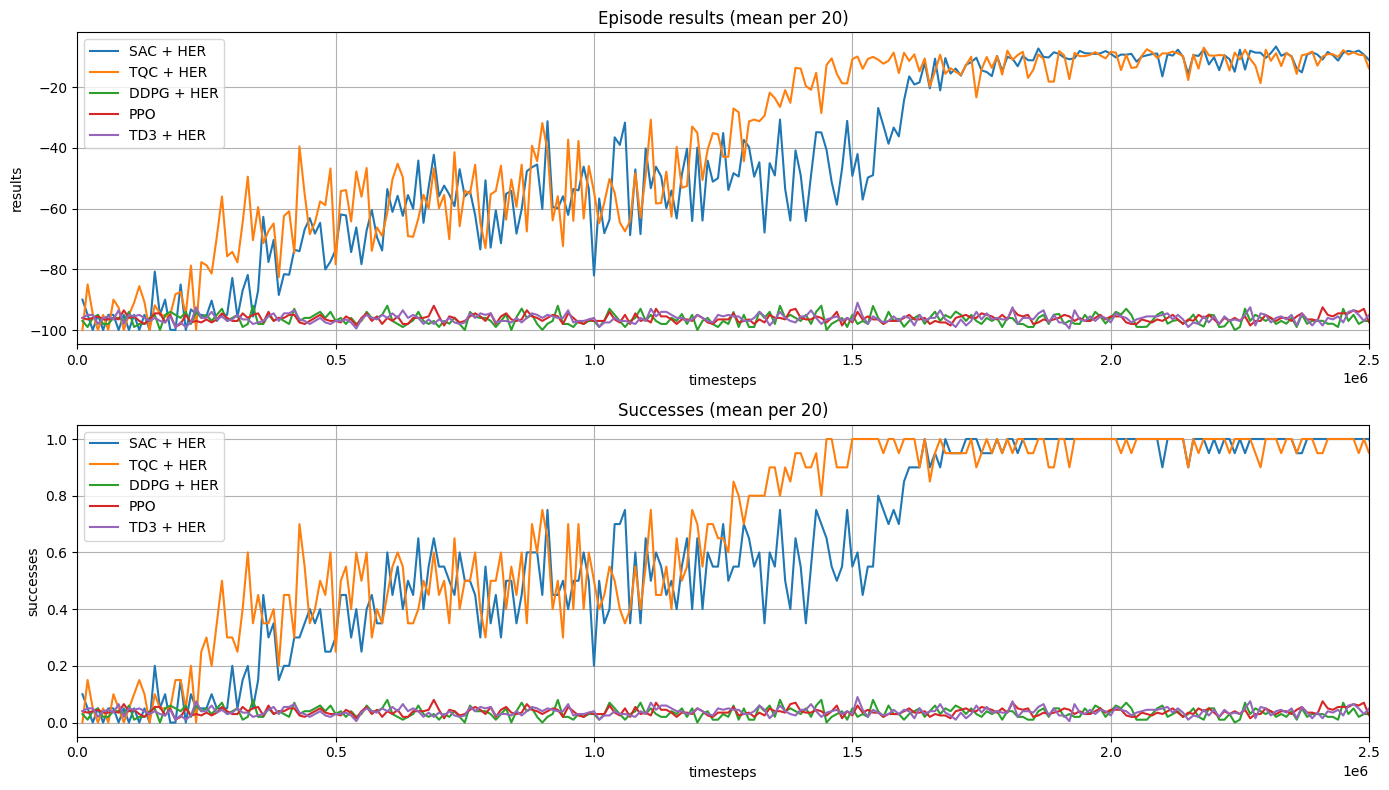

In [146]:
fig = plot_several(data_dct, max_steps=2500000)
plt.savefig("training_results.png")

## SAC trained agent

In [11]:
eval_env = DummyVecEnv([make_env(env_id, 20, render_mode="rgb_array")])

In [12]:
model_sac = SAC.load("./results/models/sac/best_model.zip", env=eval_env)

In [150]:
mean_reward, std_reward = evaluate_policy(model_sac, model.get_env(), n_eval_episodes=10)

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from stable_baselines3 import SAC

# Load your model here
# model_sac = SAC.load("your_model_path")

vec_env = model_sac.get_env()
obs = vec_env.reset()

# Function to render and display the environment
def render_and_display(env):
    frame = env.render(mode='rgb_array')
    img = Image.fromarray(frame)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for i in range(100):
    action, _states = model_sac.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    
    # Render and display the environment
    render_and_display(vec_env)

    if dones:
        obs = vec_env.reset()

/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/dtrofimov/miniconda3/envs/dl/lib/python3.11/site-packages/glfw/__init__.py:914: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


FatalError: an OpenGL platform library has not been loaded into this process, this most likely means that a valid OpenGL context has not been created before mjr_makeContext was called